# 4-9. 프로젝트 : 주식 예측에 도전해 보자

ARIMA를 통해 시계열 데이터를 예측하는 과정을 진행해 보았습니다. 이제 실제 주식값 예측에 도전해 봅시다. 데이터는 과거의 일자별 시세입니다. 우선 대한민국 대장주 삼성전자에 대한 주식 시세를 예측해 봅시다.

우선 주요 라이브러리 버전을 확인해 봅시다.

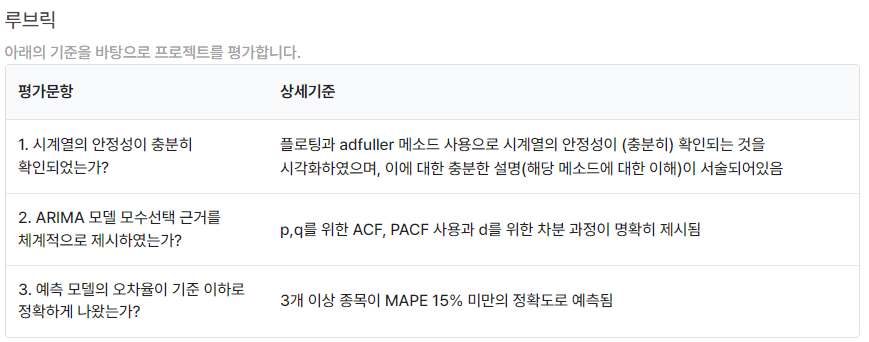

In [1]:
import pandas
import sklearn
import statsmodels

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.4.4
1.0.2
0.13.2


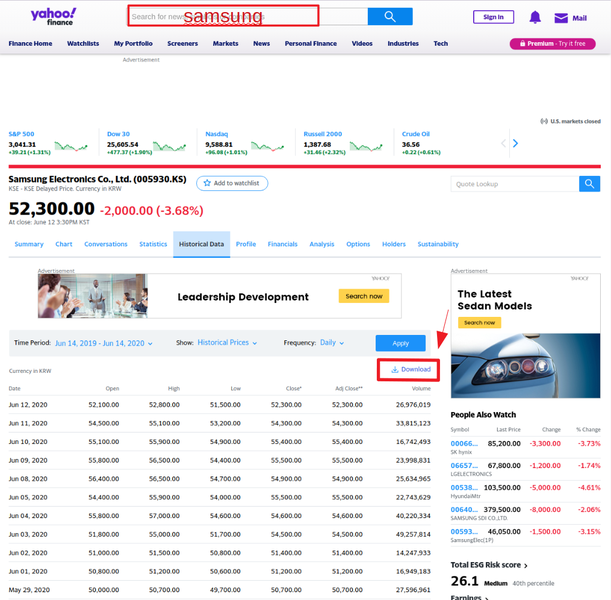

위 그림과 같이 [Yahoo Finance](https://finance.yahoo.com/)에서 오늘 사용할 데이터셋을 다운로드할 수 있습니다.

하지만 이전 스텝을 차근차근 진행하셨다면, 이미 데이터셋이 stock_prediction/data 에 올라와 있을 것입니다.
아래 명령어로 005930.KS.csv 파일이 존재하는지 확인해 봐요

### STEP 1 : 시계열 데이터 준비
---
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
- 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

```python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()
```

In [2]:
# pip install yfinance

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# 직접받아 오는 것은 김지수님 코드
import yfinance as yf
data = yf.download('005930.KS', start='2020-05-18', end='2021-05-18')
data.info()

data.head()

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 249 entries, 2020-05-18 to 2021-05-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       249 non-null    float64
 1   High       249 non-null    float64
 2   Low        249 non-null    float64
 3   Close      249 non-null    float64
 4   Adj Close  249 non-null    float64
 5   Volume     249 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.6 KB


Open     High      Low    Close     Adj Close    Volume
Date                                                                  
2020-05-18  47950.0  49100.0  47600.0  48800.0  45325.937500  20481981
2020-05-19  50100.0  50500.0  49700.0  50300.0  46719.148438  25168295
2020-05-20  50000.0  50200.0  49800.0  50000.0  46440.507812  14896899
2020-05-21  50300.0  50400.0  49850.0  49950.0  46394.066406  14949266
2020-05-22  49600.0  49800.0  48600.0  48750.0  45279.496094  19706284

- 결측치는 보이지 않는다. 

### STEP 2 : 각종 전처리 수행
---
- 결측치 처리
- 로그 변환

```python
# 결측치 처리
ts = ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

# 로그 변환 시도 
ts_log = np.log(ts)
```

- 그래프로 확인

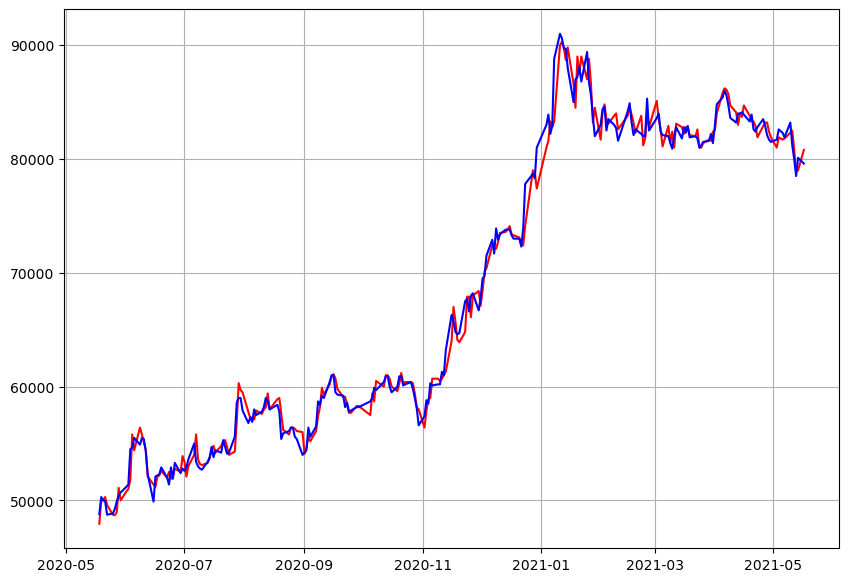

In [4]:
plt.figure(figsize = (10, 7))
plt.grid(True)
plt.plot(data['Open'], c = 'r', label = 'Open Price')
plt.plot(data['Close'], c = 'b', label = 'Close Price')
plt.legend
plt.show()

- 로그 변환 시도

In [5]:
data_log = np.log(data)
data_log.head()

Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2020-05-18  10.777914  10.801614  10.770588  10.795486  10.721635  16.835056
2020-05-19  10.821776  10.829729  10.813760  10.825760  10.751909  17.041096
2020-05-20  10.819778  10.823770  10.815770  10.819778  10.745927  16.516664
2020-05-21  10.825760  10.827746  10.816774  10.818778  10.744927  16.520173
2020-05-22  10.811746  10.815770  10.791379  10.794460  10.720610  16.796448

- 시각화

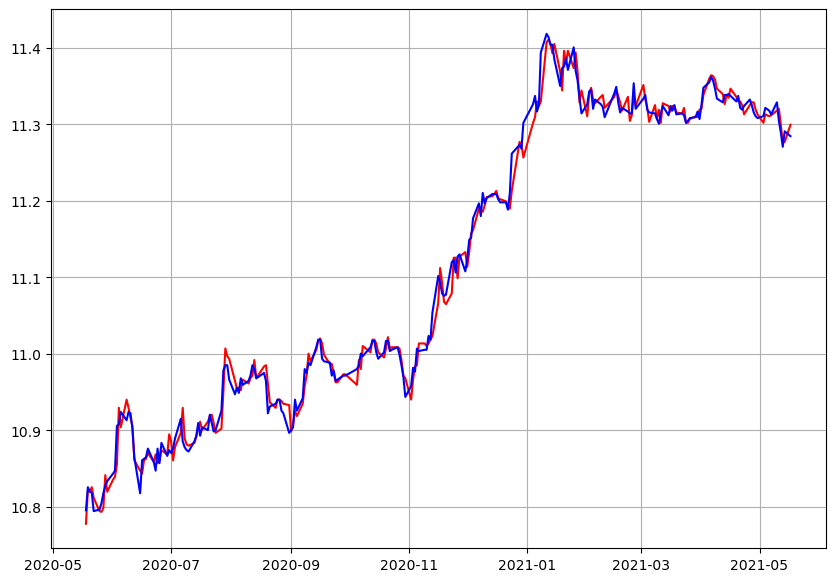

In [6]:
plt.figure(figsize = (10, 7))
plt.grid(True)
plt.plot(data_log['Open'], c = 'r', label = 'Open Price')
plt.plot(data_log['Close'], c = 'b', label = 'Close Price')
plt.legend
plt.show()

- 이동평균, 이동 표준편차를 그래프로 확인해본다. 

In [7]:
def plot_rolling_statistics(timeseries, window=7):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

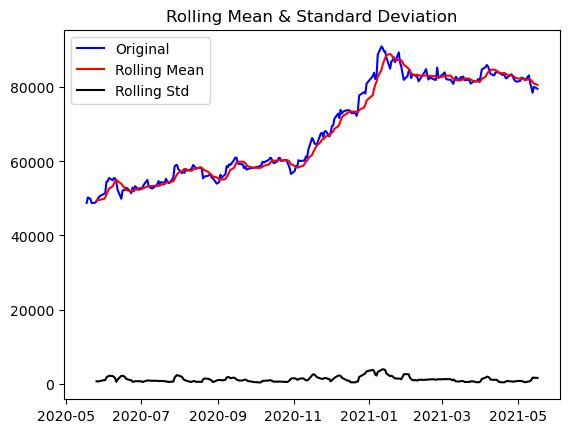

In [8]:
plot_rolling_statistics(data['Close'], window=7)

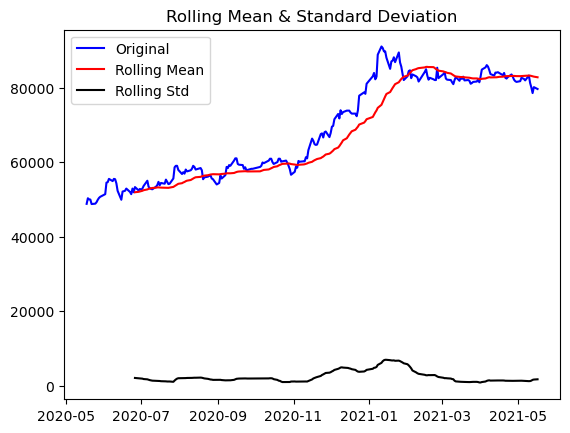

In [9]:
plot_rolling_statistics(data['Close'], window=30)

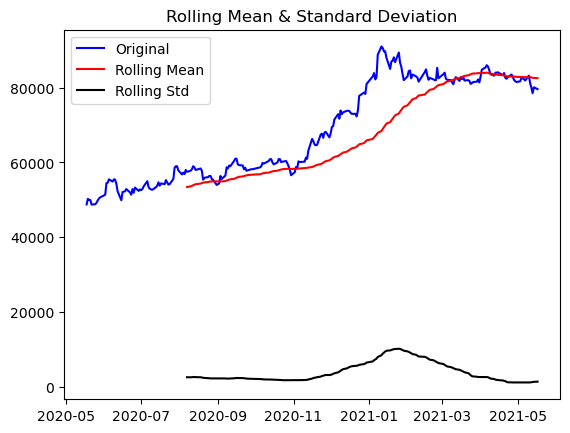

In [10]:
plot_rolling_statistics(data['Close'], window=60)

### STEP 3 : 시계열 안정성 분석
---
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

```python
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
```

In [11]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [12]:
augmented_dickey_fuller_test(data['Close'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.216246
p-value                          0.666568
#Lags Used                       0.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


In [13]:
augmented_dickey_fuller_test(data_log['Close'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.376439
p-value                          0.593518
#Lags Used                       0.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


- log화로 p-value가 새 모이만치 줄어든걸 볼수 있다. 

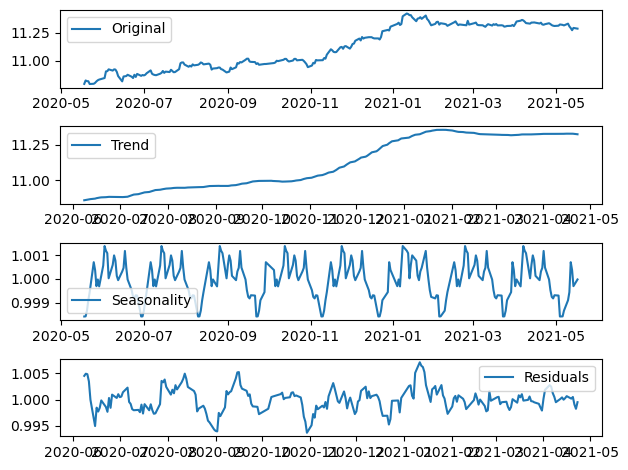

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data_log['Close'], model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(data_log['Close'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

- 기간을 달리하면 그려본다. 

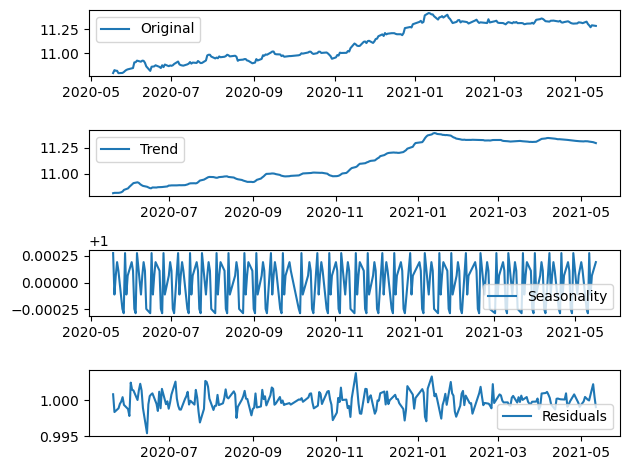

In [15]:
decomposition = seasonal_decompose(data_log['Close'], model='multiplicative', period = 7) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(data_log['Close'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

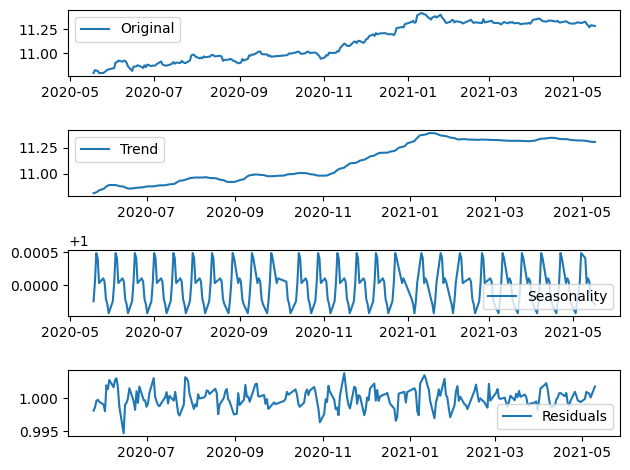

In [16]:
decomposition = seasonal_decompose(data_log['Close'], model='multiplicative', period = 10) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(data_log['Close'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

- 기간을 10일로 설정하는 것이 뭔가 더 stationary 하게 해 줄수 있을 것 같다. 

In [17]:
# 본격적으로 안정적으로 가공하기 위해 새로운 변수 할당한다. 
data_log_close = data_log['Close']

```python
# Residual 안정성 확인
# [[YOUR CODE]]
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)
```

In [18]:
decomposition = seasonal_decompose(data_log_close, model='multiplicative', period = 10) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.003783e+01
p-value                        1.524009e-17
#Lags Used                     3.000000e+00
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


In [19]:
decomposition = seasonal_decompose(data_log_close, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.181353e+00
p-value                        6.443658e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.090000e+02
Critical Value (1%)           -3.462032e+00
Critical Value (5%)           -2.875471e+00
Critical Value (10%)          -2.574195e+00
dtype: float64


In [20]:
decomposition = seasonal_decompose(data_log_close, model='multiplicative', period = 7) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -9.777134e+00
p-value                        6.886953e-17
#Lags Used                     5.000000e+00
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


- 예상이 맞았다. 10일을 시즈널 기간으로 해서 계속 진행한다. 

In [21]:
decomposition = seasonal_decompose(data_log_close, model='multiplicative', period = 10) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.003783e+01
p-value                        1.524009e-17
#Lags Used                     3.000000e+00
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


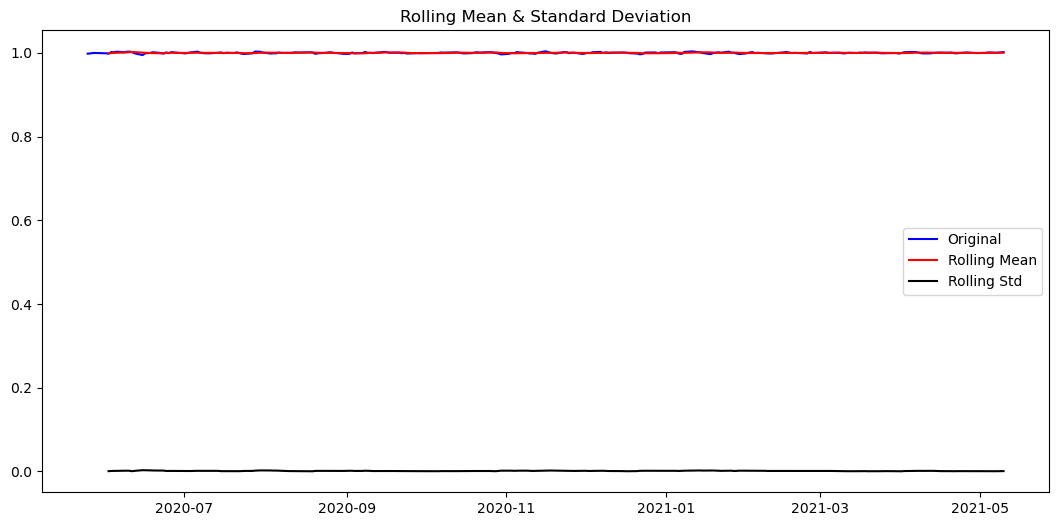

In [22]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

- 뭔가 그래프가 어처구니 없지만 일단 진행해본다. 

### STEP 4 : 학습, 테스트 데이터셋 생성
----
- 학습, 테스트 데이터셋 분리

```python
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()
```

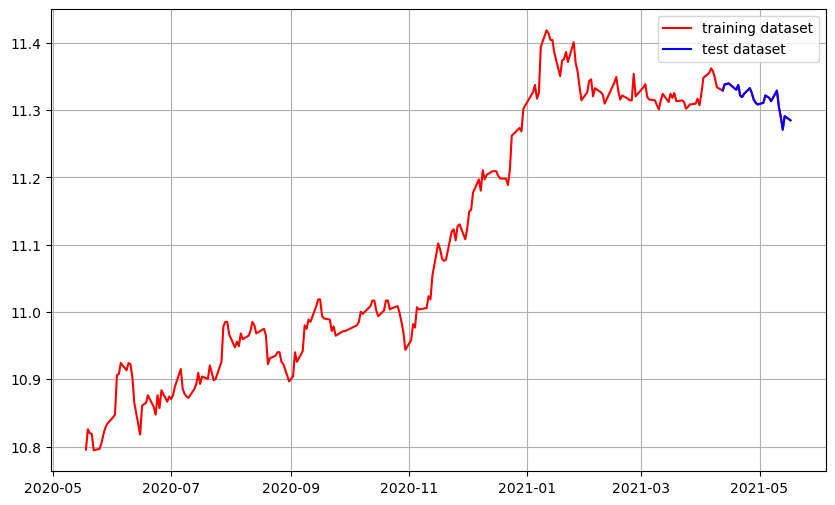

In [23]:
train_data, test_data = data_log_close[:int(len(data_log_close)*0.9)], data_log_close[int(len(data_log_close)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(data_log_close, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

### STEP 5 : 적정 ARIMA 모수 찾기
----
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

```pthon
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()
```

In [24]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# [[YOUR CODE]]

C:\Users\aeoli\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


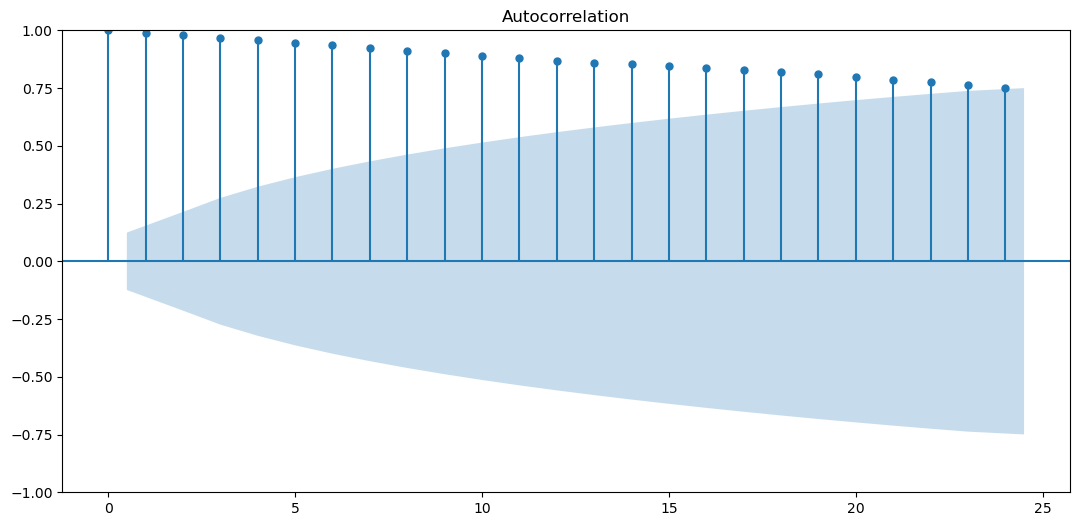

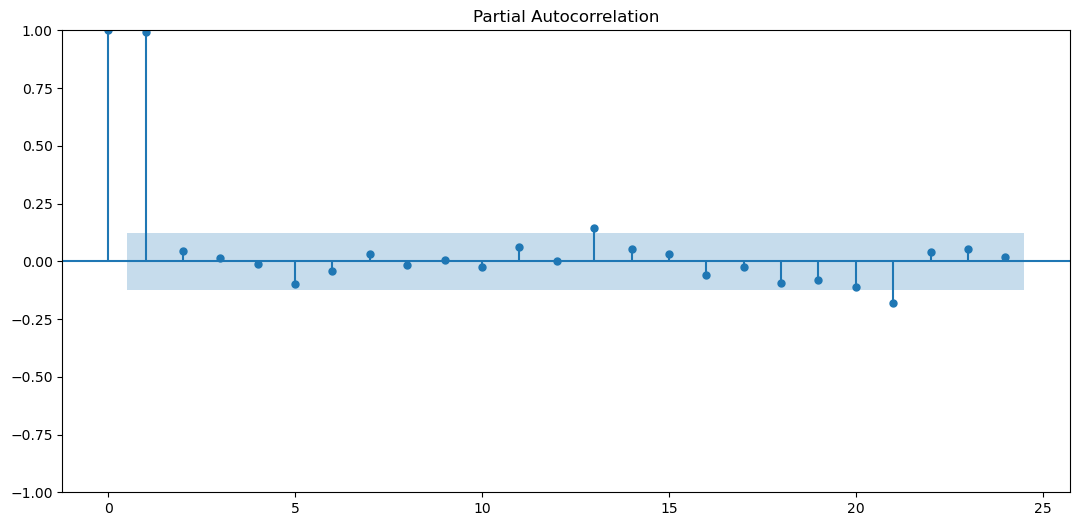

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_log_close)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(data_log_close)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

```python
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)
```

<AxesSubplot:title={'center':'Difference 1st'}, xlabel='Date'>

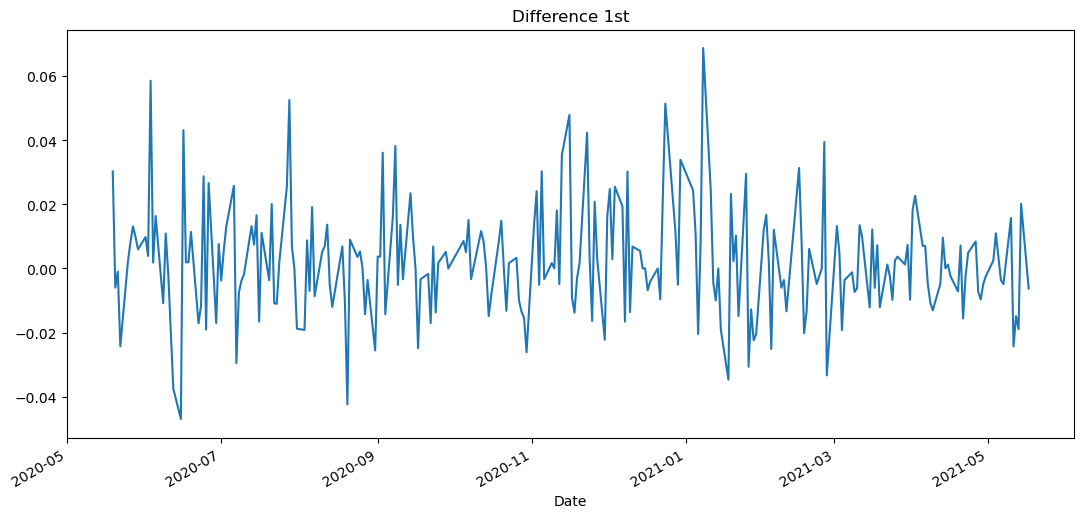

In [26]:
# 1차 차분 구하기
diff_1 = data_log_close.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

In [27]:
# 차분 안정성 확인 -> d 구하기
# [[YOUR CODE]]
diff_1.dropna(inplace=True)
augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.550157e+01
p-value                        2.411857e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.470000e+02
Critical Value (1%)           -3.457105e+00
Critical Value (5%)           -2.873314e+00
Critical Value (10%)          -2.573044e+00
dtype: float64


- 어마어마 한 값이 나왔다

### STEP 6 : ARIMA 모델 훈련과 테스트
---
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

```python
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(2, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())
```

In [28]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima.model import ARIMA

# Build and Train  Model
# [[YOUR CODE]]
model = ARIMA(train_data, order=(1, 0, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  224
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 580.031
Date:                Sun, 20 Nov 2022   AIC                          -1154.063
Time:                        21:20:59   BIC                          -1143.828
Sample:                             0   HQIC                         -1149.931
                                - 224                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0885      0.118     94.050      0.000      10.857      11.320
ar.L1          0.9939      0.006    167.822      0.000       0.982       1.005
sigma2         0.0003   2.47e-05     13.082      0.0

In [29]:
# fitted_m = fitted_m.predict()
# fitted_m = fitted_m.drop(fitted_m.index[0])
# plt.plot(fitted_m, label='predict')
# plt.plot(train_data, label='train_data')
# plt.legend()

```python
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()
```

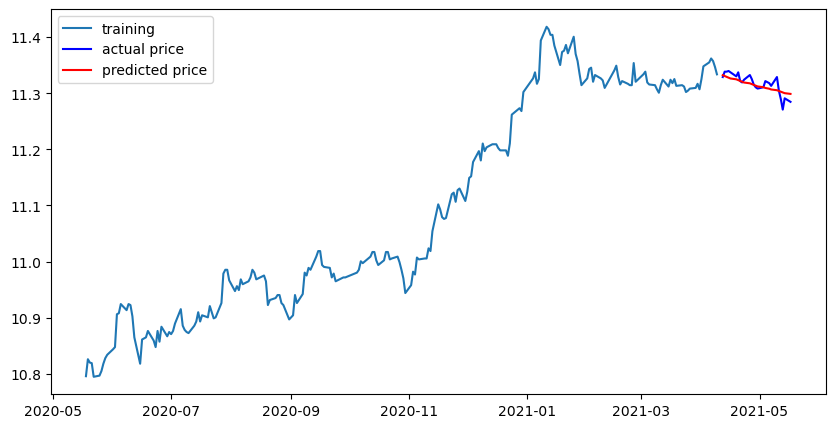

In [30]:
# Forecast : 결과가 fc에 담깁니다. 
# [[YOUR CODE]]

# Make as pandas series
# [[YOUR CODE]]

# Plot
# [[YOUR CODE]]
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

```python
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))
```

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  858739.6652904886
MAE:  720.7475079289352
RMSE:  926.6820734699083
MAPE: 0.88%


- 다른 p값을 주고 테스트 해본다. 

In [32]:
model = ARIMA(train_data, order=(21, 1, 0))  
fitted_m = model.fit() 

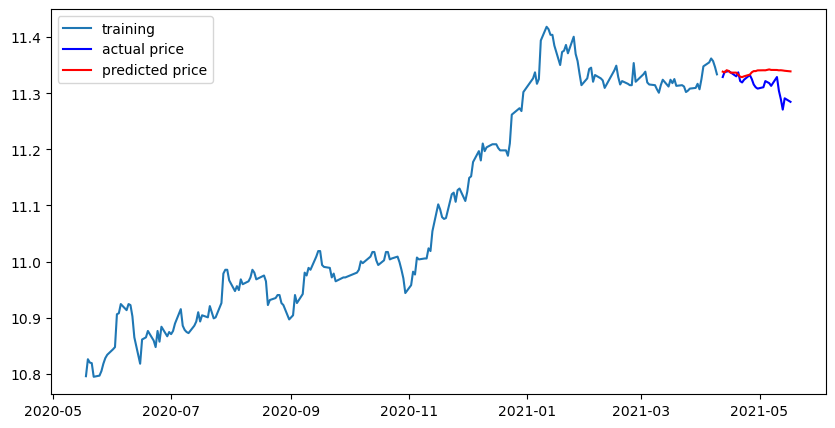

In [33]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [34]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  5401795.997374024
MAE:  1724.013902403927
RMSE:  2324.1764127049446
MAPE: 2.13%


In [35]:
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit() 

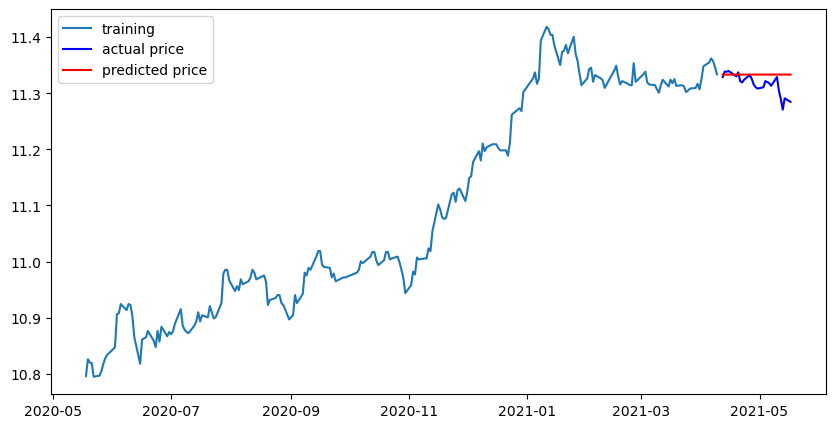

In [36]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [37]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3791692.380995481
MAE:  1450.0261365407466
RMSE:  1947.2268437435534
MAPE: 1.79%


### 가장 정확도가 높은 모델은 p=1, d=0, q=0인 모델이다. 
- 1차차분의 안정성이 매우 높았는데 d=1이렇게 줬을 경우 정확도가 오히려 떨어졌다. 
- 여전히 pdq의 관계가 명확히 들어오지 않는다. 
- 시계열 안정성 분석과 ARIMA의 관계가 명확히 설명되지 않는다. 
--------
#### 최종 결과 그래프를 다시 그린다. 

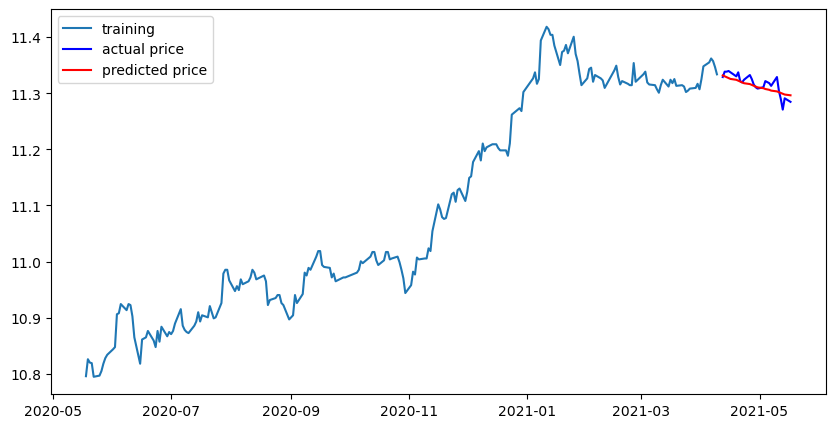

In [38]:
model = ARIMA(train_data, order=(1, 0, 2))  
fitted_m = model.fit() 

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [39]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  888966.2710677119
MAE:  746.6314063359168
RMSE:  942.8500787865014
MAPE: 0.91%


### STEP 7 : 다른 주식 종목 예측해 보기
---
관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기

### 관심종목 3종 테스트
- 이왕 테크주로 시작했으니 나머지 3개 종목도 테크 주로 해보자 
1. TSMC
2. ASML
3. INTEL

- 처리 순서는 다음과 같다. 
    1. 결측치 확인하고 로그변환 시도한다. 
    2. 이동평균과 이동표준편차를 시계열 그래프로 확인한다. 
    3. 시계열 안정성 분석을 위해 오그멘티드 디키풀러 테스트를 진행하고 적절한 페리오드 찾는다. 
    4. 학습데이터를 만들고
    5. 시계열 안정성 분석 결과를 통해 적절한 ARIMA모수를 찾는다. 
    6. 모델 훈련 및 평가를 진행한다. 

## TSMC
- 팹리스 반도체 회사와 생산을 대행해주는 파운드리 회사라는 개념을 만들어낸 입지전적인 회사
- 한때 생산 대행이라는 틀에 갖혀 저평가 되었으나 선단공정으로 갈수록 반도체 설계능력 못지 않게 생산늘력이 반도체 성능에 미치는 영향이 크다는 점이 드러나서 대 약진중이다. 
- 인텔과 삼성이 머뭇거리는 사이 반도체 회사 최대 매출회사가 되었다. 
- 똑같이 종가 기준으로 훈련과 예측을 한다. 

In [40]:
import yfinance as yf
data = yf.download('TSMC34.SA', start='2020-05-18', end='2022-05-18')
data.info()

data.head()

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 496 entries, 2020-05-18 to 2022-05-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       496 non-null    float64
 1   High       496 non-null    float64
 2   Low        496 non-null    float64
 3   Close      496 non-null    float64
 4   Adj Close  496 non-null    float64
 5   Volume     496 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 27.1 KB


Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2020-05-18  36.599998  37.000000  36.599998  37.000000  35.220474    1920
2020-05-19  36.564999  36.564999  36.564999  36.564999  34.806389     800
2020-05-20  37.012501  37.012501  37.012501  37.012501  35.232368    1040
2020-05-21  35.875000  35.875000  35.543751  35.543751  33.834255   13600
2020-05-22  34.987499  34.987499  34.987499  34.987499  33.304764     320

#### 그래프 확인 및 로그 그래프 확인

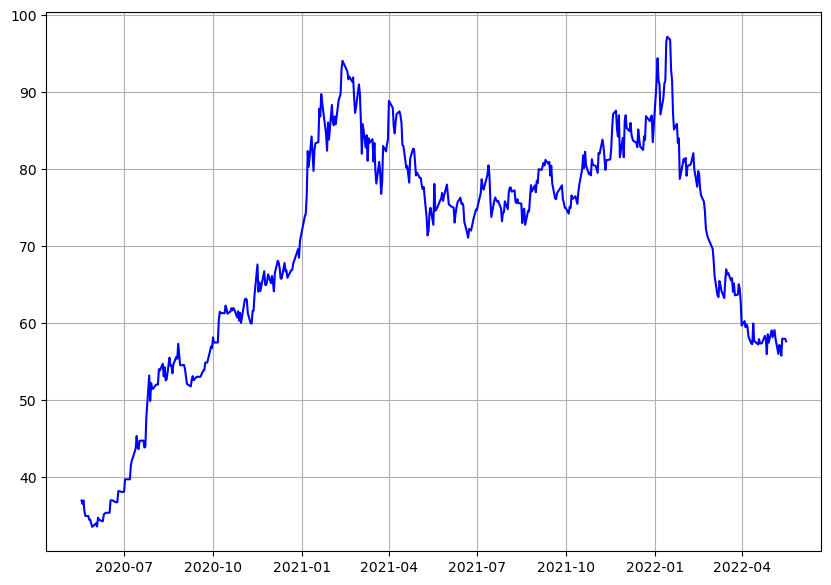

In [41]:
plt.figure(figsize = (10, 7))
plt.grid(True)
plt.plot(data['Close'], c = 'b', label = 'Close Price')
plt.legend
plt.show()

In [42]:
tsmc_log = np.log(data['Close'])
tsmc_log

Date
2020-05-18    3.610918
2020-05-19    3.599091
2020-05-20    3.611256
2020-05-21    3.570764
2020-05-22    3.554991
                ...   
2022-05-11    4.036539
2022-05-12    4.021595
2022-05-13    4.060271
2022-05-16    4.060271
2022-05-17    4.054390
Name: Close, Length: 496, dtype: float64

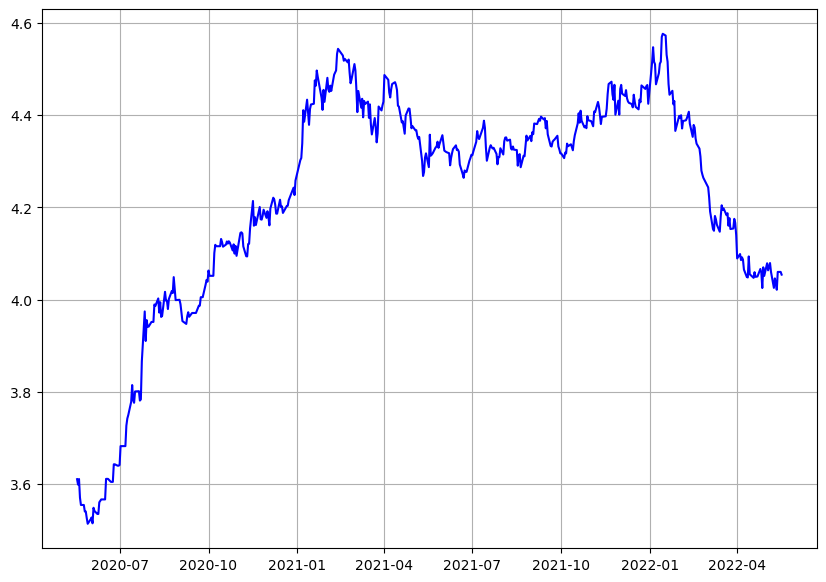

In [43]:
plt.figure(figsize = (10, 7))
plt.grid(True)
plt.plot(tsmc_log, c = 'b')
plt.show()

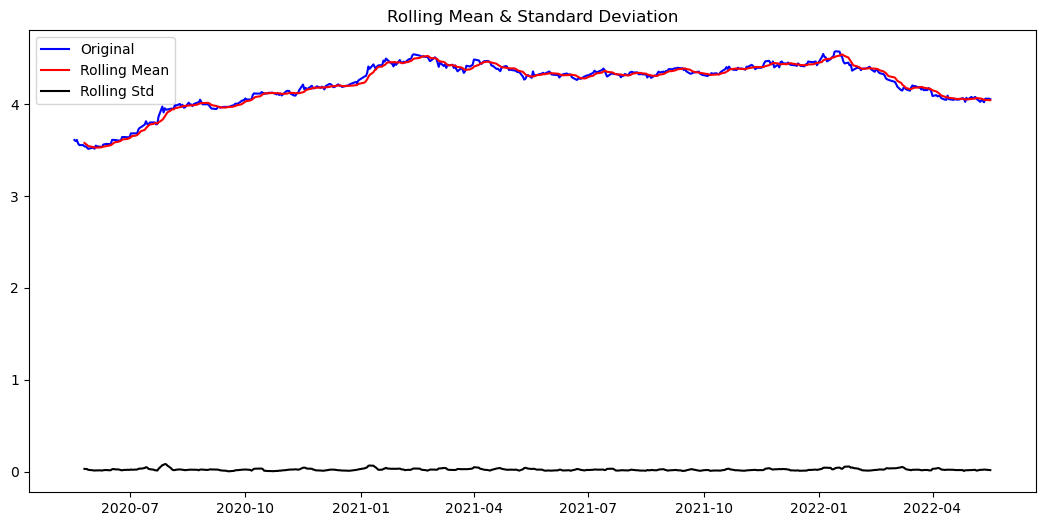

In [44]:
plot_rolling_statistics(tsmc_log, window=7)

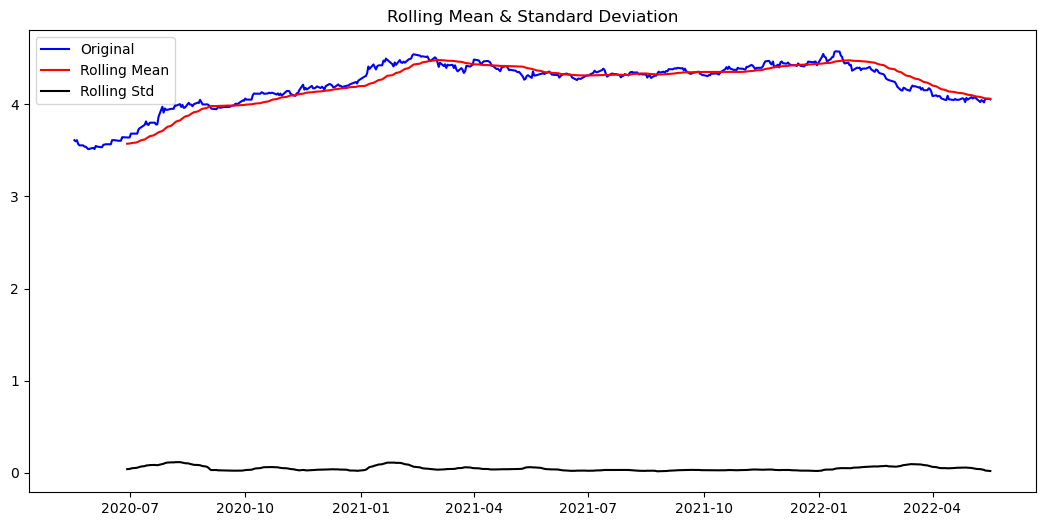

In [45]:
plot_rolling_statistics(tsmc_log, window=30)

In [46]:
augmented_dickey_fuller_test(tsmc_log)

Results of Dickey-Fuller Test:
Test Statistic                  -2.531150
p-value                          0.108078
#Lags Used                       1.000000
Number of Observations Used    494.000000
Critical Value (1%)             -3.443657
Critical Value (5%)             -2.867408
Critical Value (10%)            -2.569896
dtype: float64


- p-value가 만족스럽지 않기 때문에 데이터 가공을 시도한다. 

#### 시계열 안정성 분석을 진행한다. 

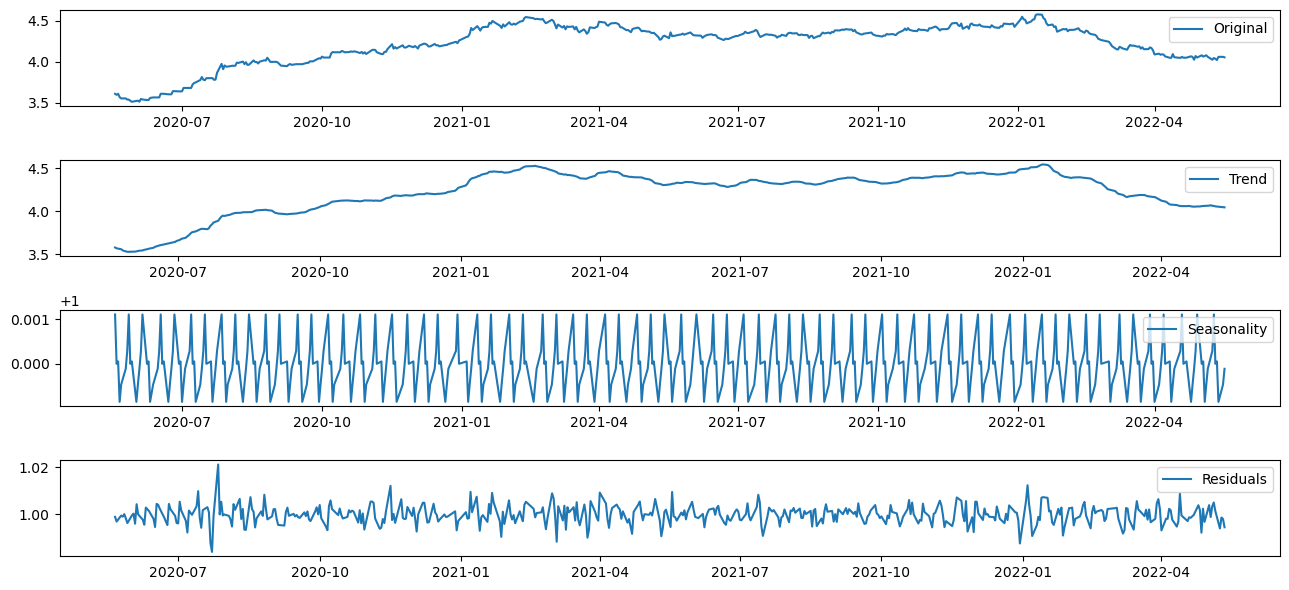

In [47]:
decomposition = seasonal_decompose(tsmc_log, model='multiplicative', period = 7) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(tsmc_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [48]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -9.000523e+00
p-value                        6.516379e-15
#Lags Used                     1.700000e+01
Number of Observations Used    4.720000e+02
Critical Value (1%)           -3.444281e+00
Critical Value (5%)           -2.867683e+00
Critical Value (10%)          -2.570042e+00
dtype: float64


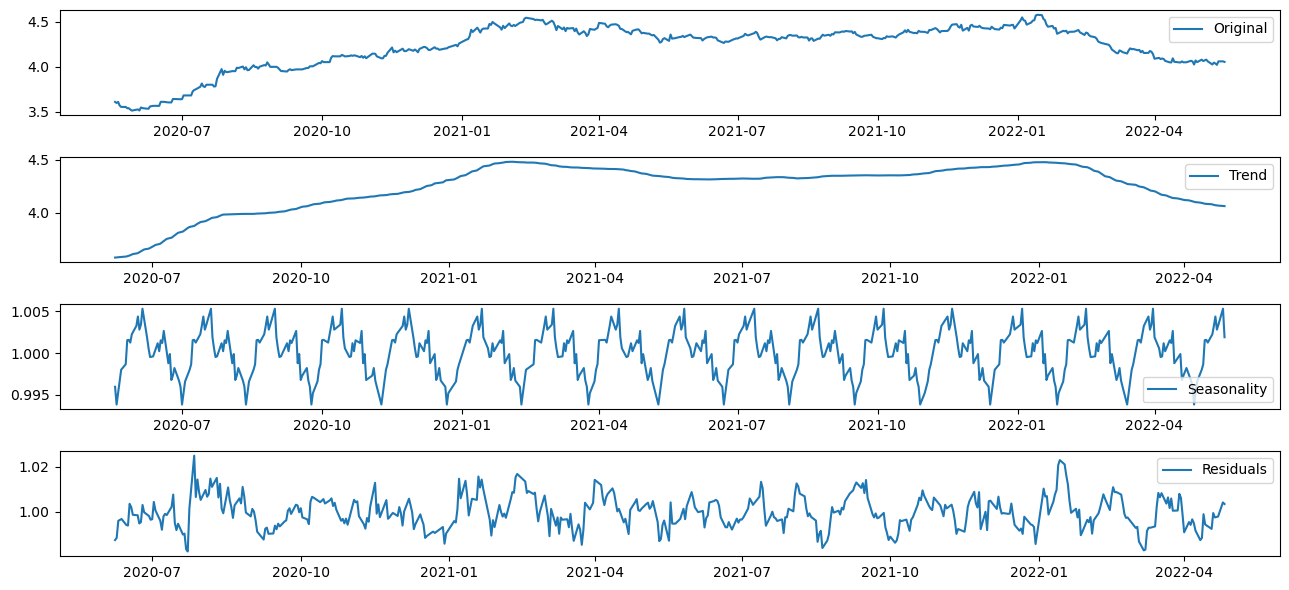

In [49]:
decomposition = seasonal_decompose(tsmc_log, model='multiplicative', period = 30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(tsmc_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [50]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -8.241437e+00
p-value                        5.702951e-13
#Lags Used                     1.100000e+01
Number of Observations Used    4.540000e+02
Critical Value (1%)           -3.444836e+00
Critical Value (5%)           -2.867927e+00
Critical Value (10%)          -2.570172e+00
dtype: float64


- period는 7이 좋아보이고 충분한 p value값을 도출했다. 

#### 훈련 데이터 생성한다. 

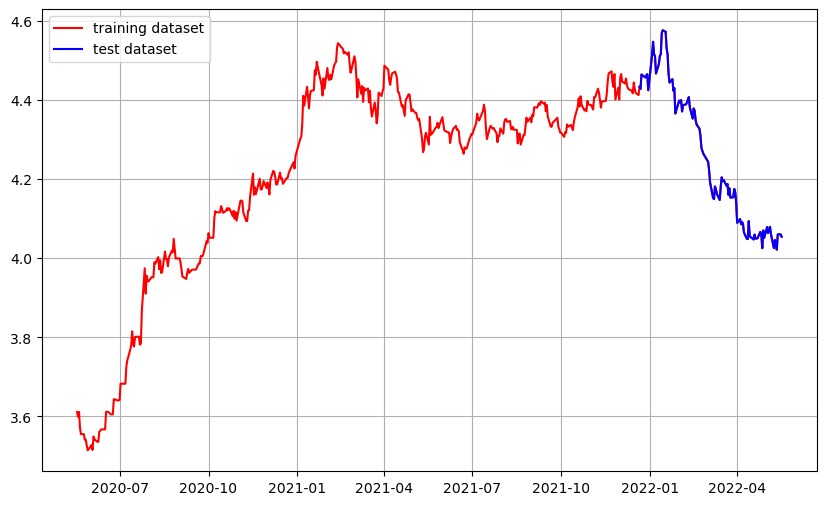

In [51]:
train_data, test_data = tsmc_log[:int(len(tsmc_log)*0.8)], tsmc_log[int(len(tsmc_log)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(tsmc_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

- 훈련데이터 테스트 데이터 비율을 9:1로 하면 폭락구간에서 예측을 하는것이기 때문에 폭락이 오기전으로 시도해본다. 

#### 차분 횟수를 확인한다. 

Results of Dickey-Fuller Test:
Test Statistic                 -25.346590
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    494.000000
Critical Value (1%)             -3.443657
Critical Value (5%)             -2.867408
Critical Value (10%)            -2.569896
dtype: float64


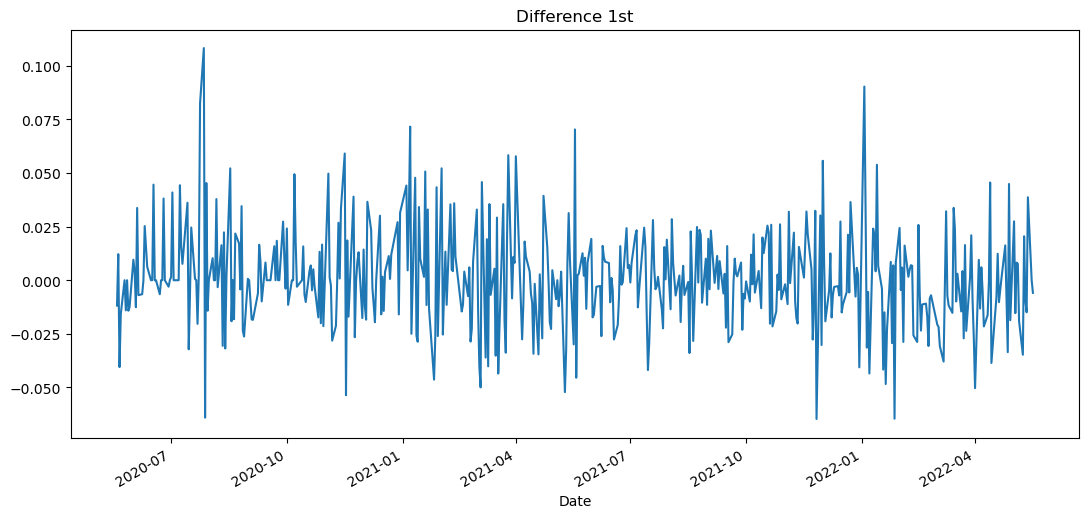

In [52]:
# 1차 차분 구하기
tsmc_diff_1 = tsmc_log.diff(periods=1).iloc[1:]
tsmc_diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(tsmc_diff_1)

In [53]:
# # 1차 차분 구하기
# tsmc_diff_1 = tsmc_log.diff(periods=7).iloc[7:]
# tsmc_diff_1.plot(title='Difference 1st')

# augmented_dickey_fuller_test(tsmc_diff_1)

- acf 및 pacf 그래프를 그려본다. 

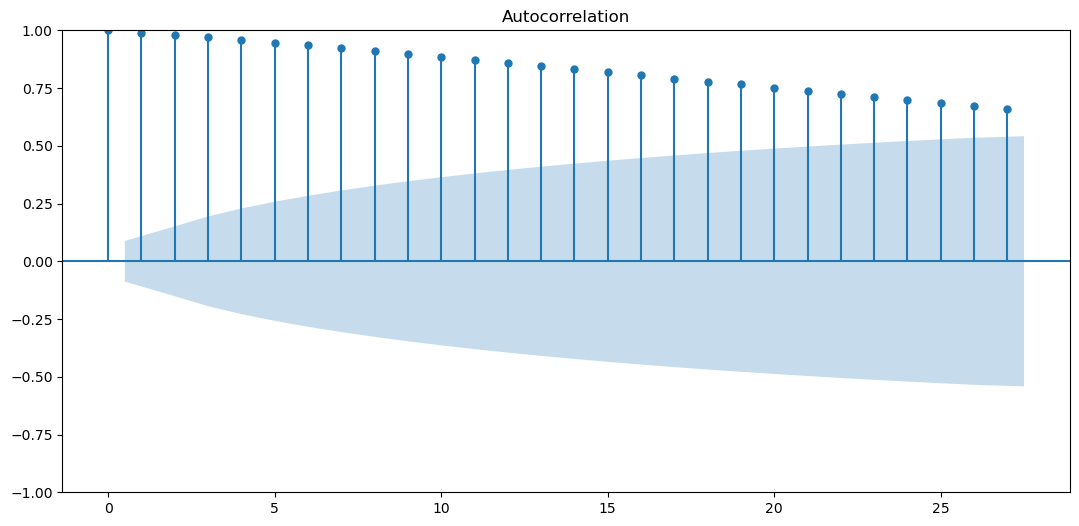

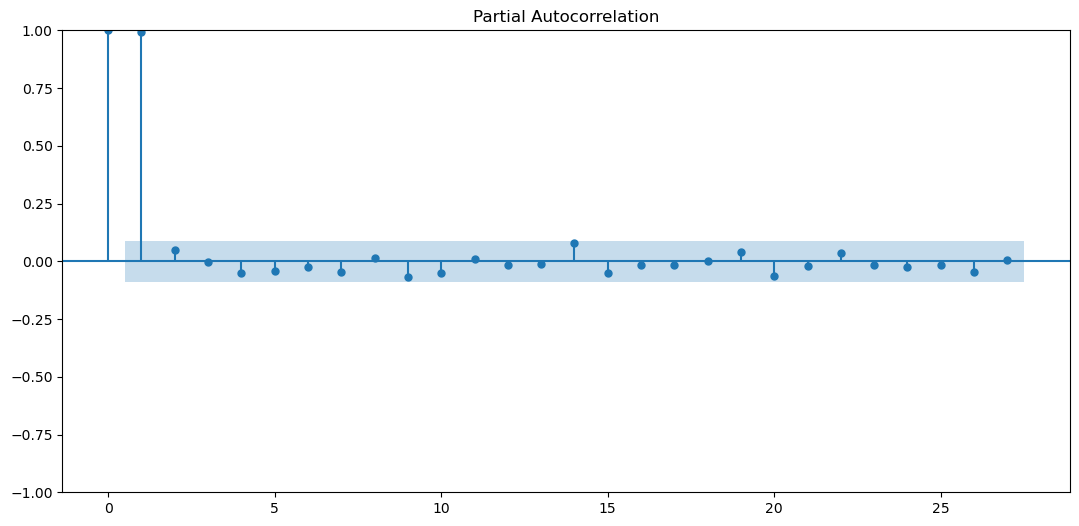

In [54]:
plot_acf(tsmc_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(tsmc_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

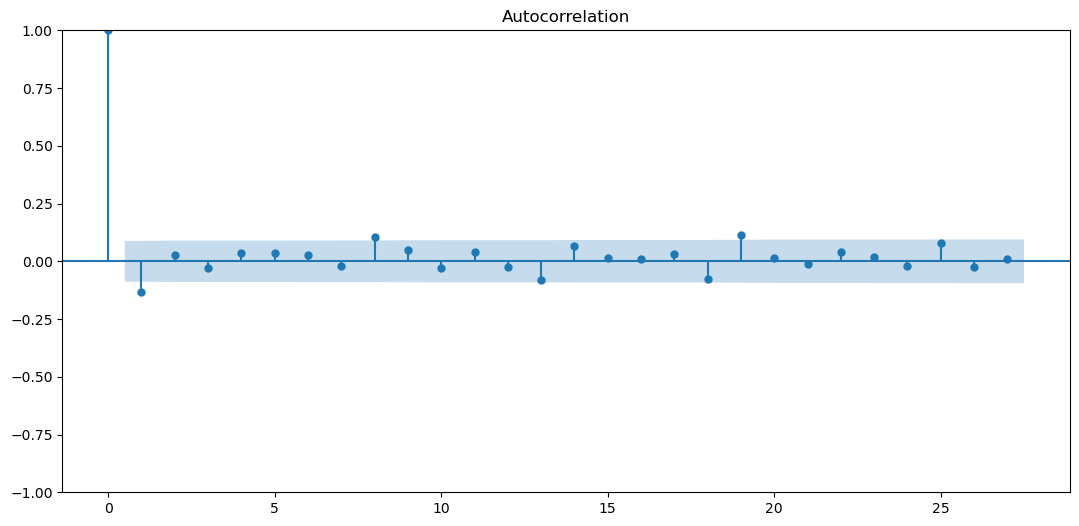

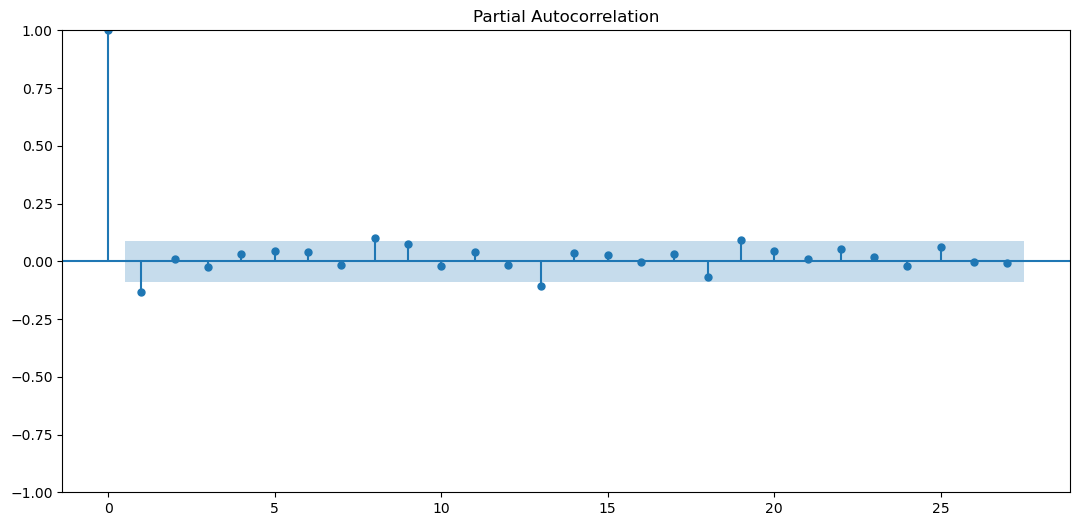

In [55]:
plot_acf(tsmc_diff_1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(tsmc_diff_1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- p=1, d=1, q=1을 기본으로 테스트를 진행해본다. 
- p=1, d=0, q=2도 시도해본다. 

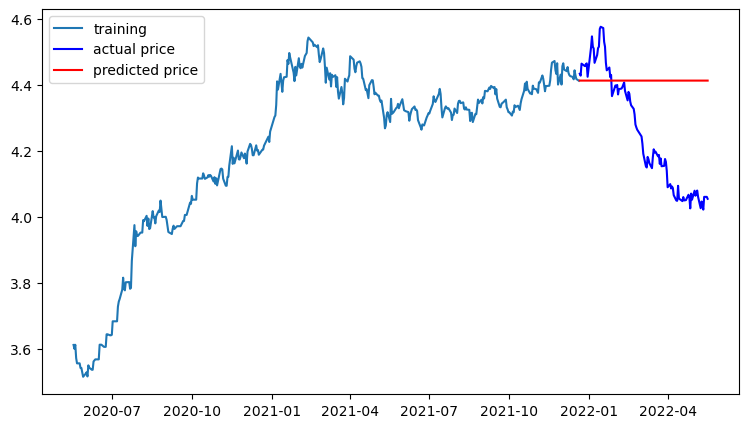

In [62]:
model = ARIMA(train_data, order=(1, 1, 1))
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [63]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  273.9090869302462
MAE:  13.952045585853845
RMSE:  16.55019899971738
MAPE: 21.94%


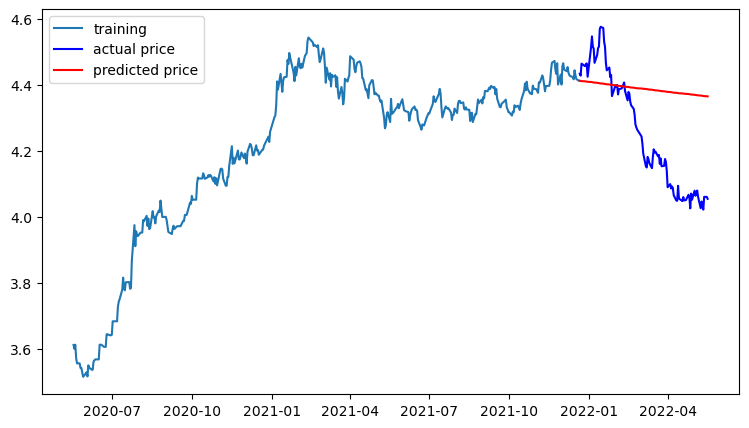

In [64]:
model = ARIMA(train_data, order=(1, 0, 2))
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [65]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  209.37290507812355
MAE:  12.24133032082042
RMSE:  14.469723738832181
MAPE: 19.14%


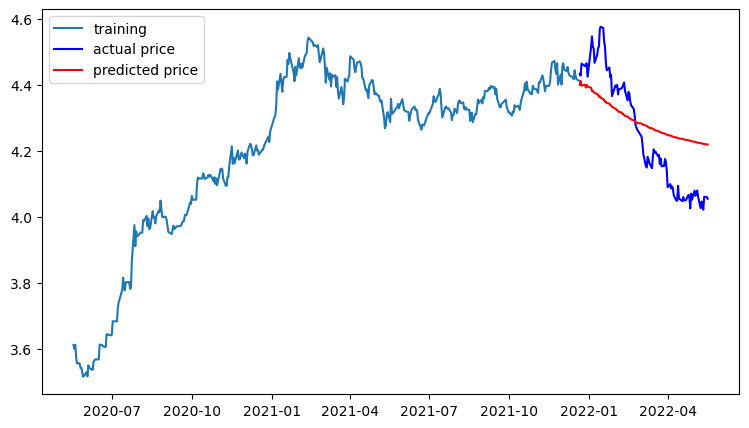

In [70]:
model = ARIMA(train_data, order=(21, 0, 0))
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [71]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  79.28763167238206
MAE:  8.038017768577895
RMSE:  8.90436026182578
MAPE: 11.66%


## ASML
- 반도체 제작 공정중 가장 중요한 장비중 하나인 노광장비의 절대강자
- 한때 일본업체와 시장에서 치열한 경쟁을 벌였으나
- EUV 노광장비 시대의 도래와 함께 EUV 노광장비 개발에 실패한 일본업체를 제치고 사실상 시장 독과점 업체임

In [75]:
import yfinance as yf
data = yf.download('ASML', start='2020-05-18', end='2022-05-18')
data.info()

data.head()

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 505 entries, 2020-05-18 to 2022-05-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       505 non-null    float64
 1   High       505 non-null    float64
 2   Low        505 non-null    float64
 3   Close      505 non-null    float64
 4   Adj Close  505 non-null    float64
 5   Volume     505 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 27.6 KB


Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-05-18  297.690002  306.559998  297.660004  304.890015  298.210052   
2020-05-19  303.820007  311.989990  303.730011  306.250000  299.540222   
2020-05-20  318.239990  326.260010  317.549988  325.640015  318.505432   
2020-05-21  322.600006  324.459991  317.299988  318.989990  312.001129   
2020-05-22  315.970001  319.500000  314.320007  319.359985  312.363037   

             Volume  
Date                 
2020-05-18   997000  
2020-05-19   687400  
2020-05-20  1084900  
2020-05-21   639200  
2020-05-22   365400

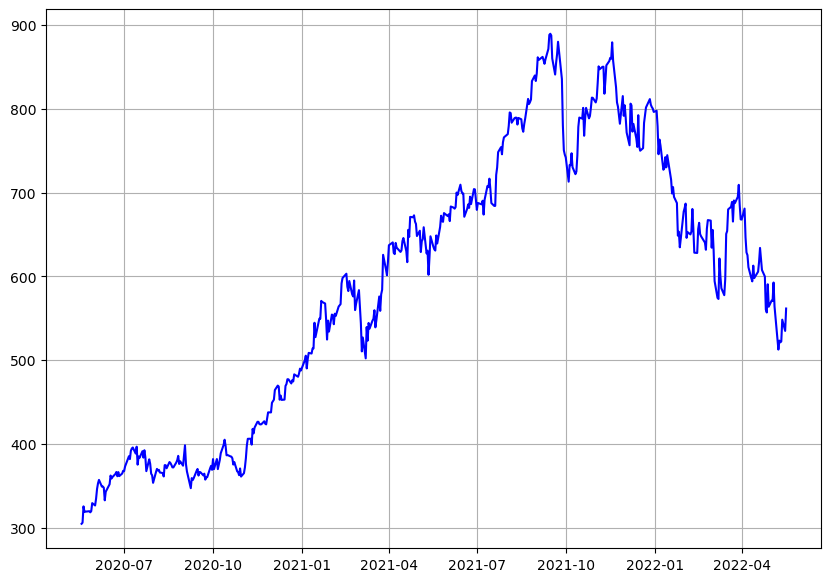

In [76]:
plt.figure(figsize = (10, 7))
plt.grid(True)
plt.plot(data['Close'], c = 'b', label = 'Close Price')
plt.legend
plt.show()

In [77]:
asml_log = np.log(data['Close'])
asml_log

Date
2020-05-18    5.719951
2020-05-19    5.724402
2020-05-20    5.785793
2020-05-21    5.765160
2020-05-22    5.766319
                ...   
2022-05-11    6.256326
2022-05-12    6.258357
2022-05-13    6.306859
2022-05-16    6.282173
2022-05-17    6.330843
Name: Close, Length: 505, dtype: float64

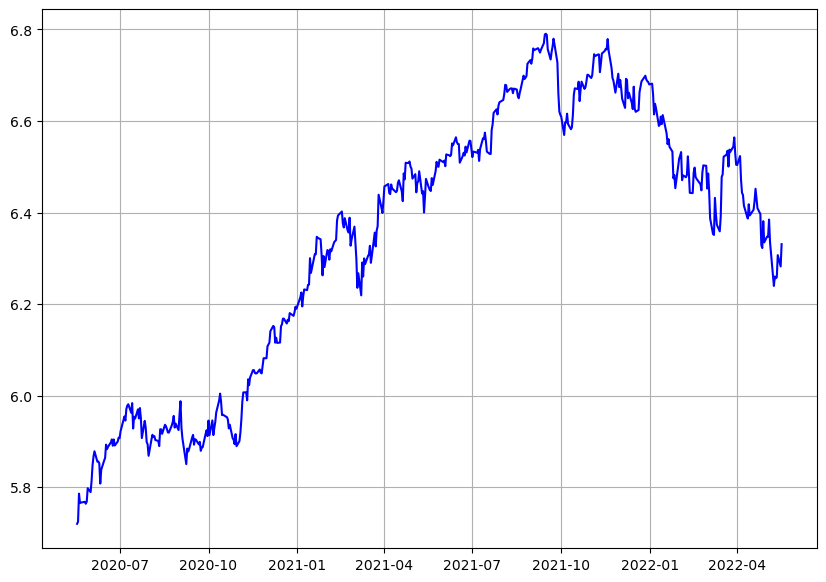

In [78]:
plt.figure(figsize = (10, 7))
plt.grid(True)
plt.plot(asml_log, c = 'b')
plt.show()

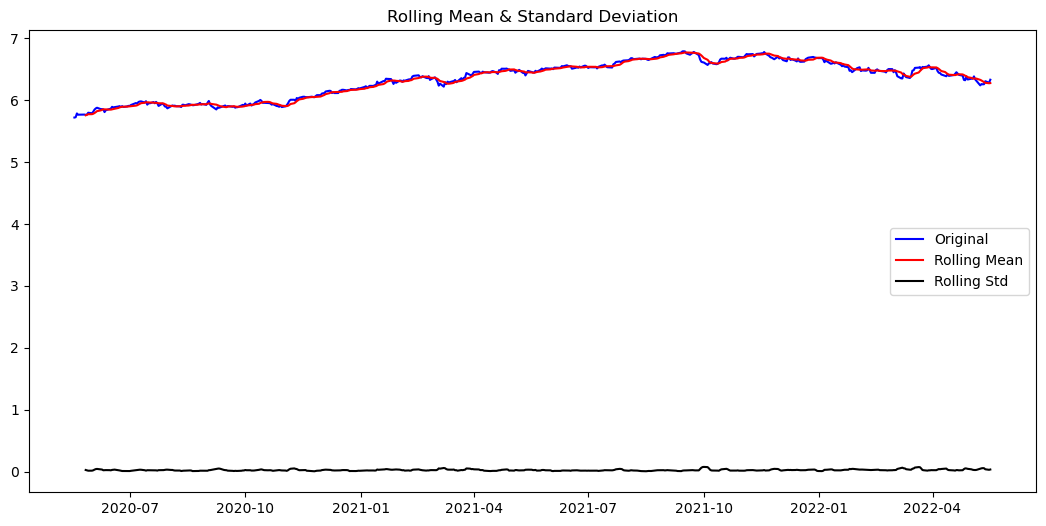

In [79]:
plot_rolling_statistics(asml_log, window=7)

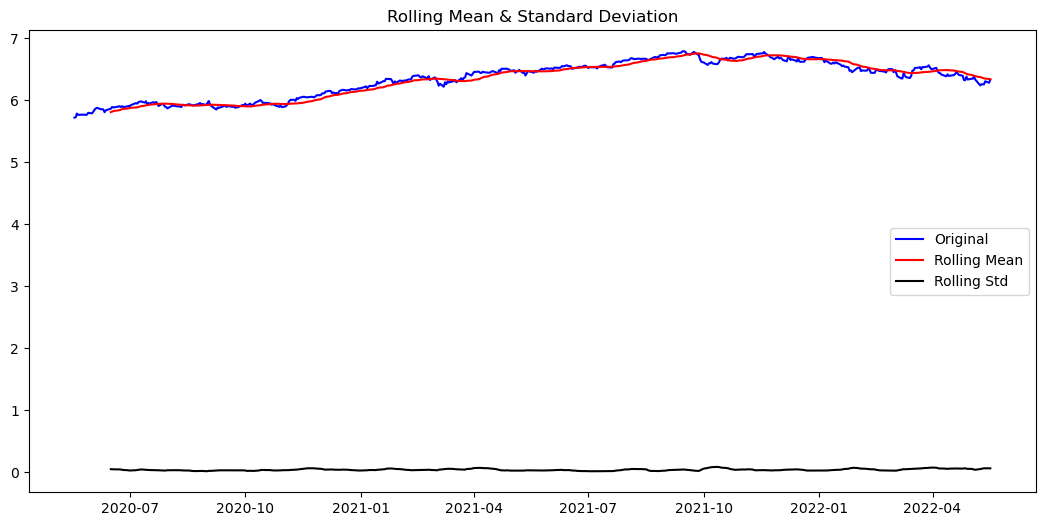

In [80]:
plot_rolling_statistics(asml_log, window=21)

#### 시계열 안정성 분석을 진행한다. 

In [81]:
augmented_dickey_fuller_test(asml_log)

Results of Dickey-Fuller Test:
Test Statistic                  -2.015191
p-value                          0.279952
#Lags Used                       3.000000
Number of Observations Used    501.000000
Critical Value (1%)             -3.443470
Critical Value (5%)             -2.867326
Critical Value (10%)            -2.569852
dtype: float64


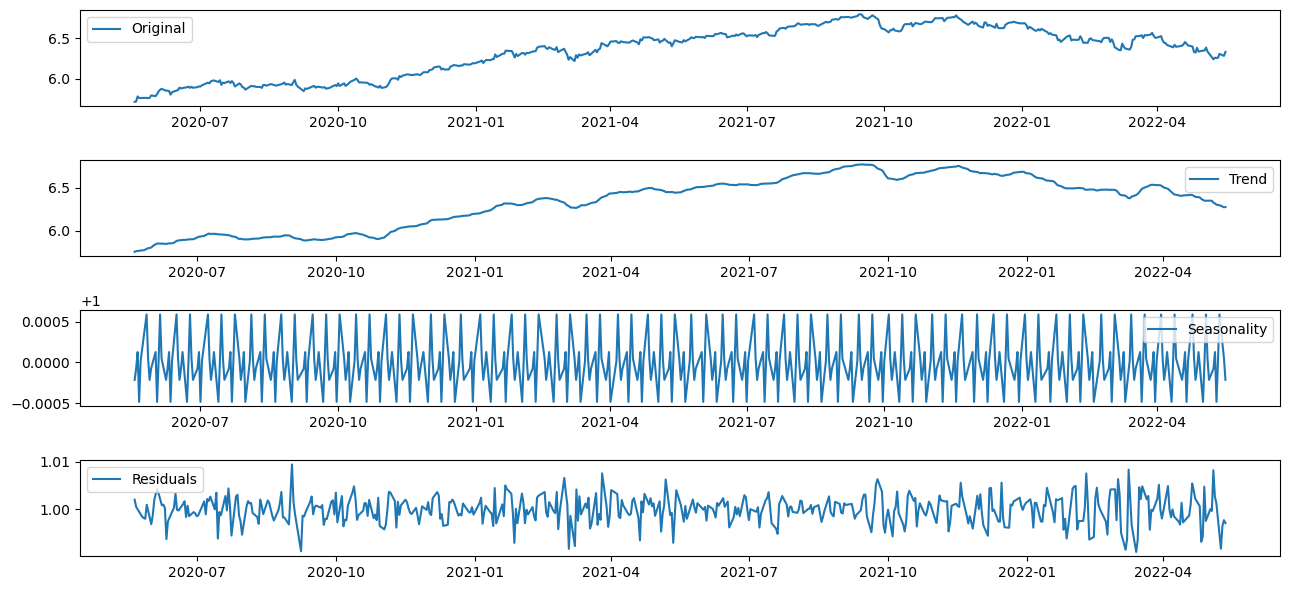

In [84]:
decomposition = seasonal_decompose(asml_log, model='multiplicative', period = 7) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(asml_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [85]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -9.020639e+00
p-value                        5.788148e-15
#Lags Used                     1.800000e+01
Number of Observations Used    4.800000e+02
Critical Value (1%)           -3.444047e+00
Critical Value (5%)           -2.867580e+00
Critical Value (10%)          -2.569987e+00
dtype: float64


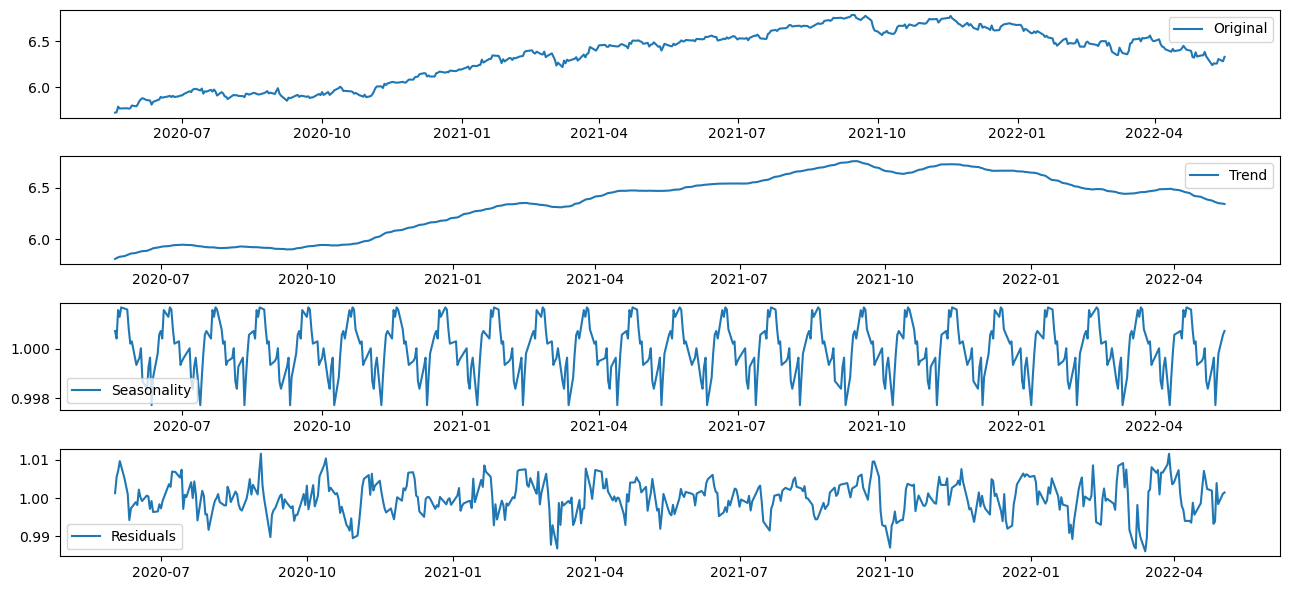

In [86]:
decomposition = seasonal_decompose(asml_log, model='multiplicative', period = 21) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(asml_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [87]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -9.403412e+00
p-value                        6.101179e-16
#Lags Used                     7.000000e+00
Number of Observations Used    4.770000e+02
Critical Value (1%)           -3.444134e+00
Critical Value (5%)           -2.867618e+00
Critical Value (10%)          -2.570008e+00
dtype: float64


- period는 21이 좋아보이고, 충분한 p-value를 확인했다. 

#### 훈련데이터 생성한다. 

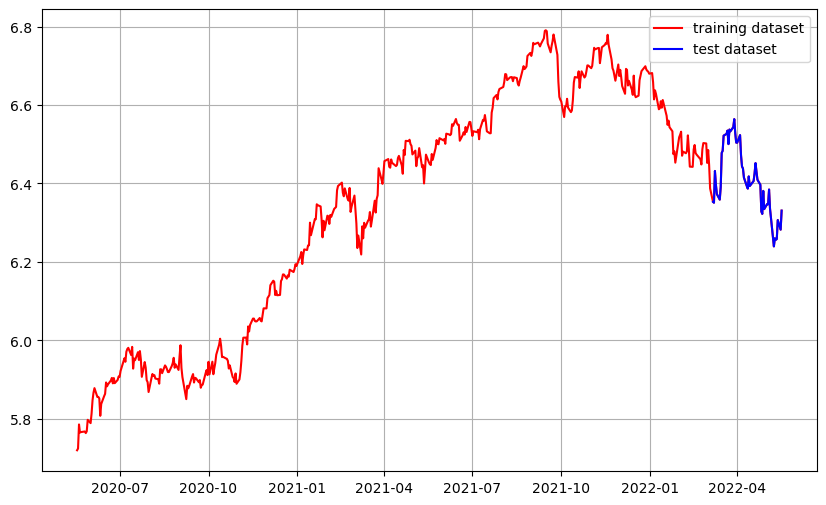

In [89]:
train_data, test_data = asml_log[:int(len(asml_log)*0.9)], asml_log[int(len(asml_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(asml_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

- 하락 추세속 반든 모멘트를 예측 가능한지 확인하기 위해 0.9를 훈련데이터로 한다. 

#### 차분횟수를 확인한다. 

Results of Dickey-Fuller Test:
Test Statistic                -1.400279e+01
p-value                        3.835197e-26
#Lags Used                     2.000000e+00
Number of Observations Used    5.010000e+02
Critical Value (1%)           -3.443470e+00
Critical Value (5%)           -2.867326e+00
Critical Value (10%)          -2.569852e+00
dtype: float64


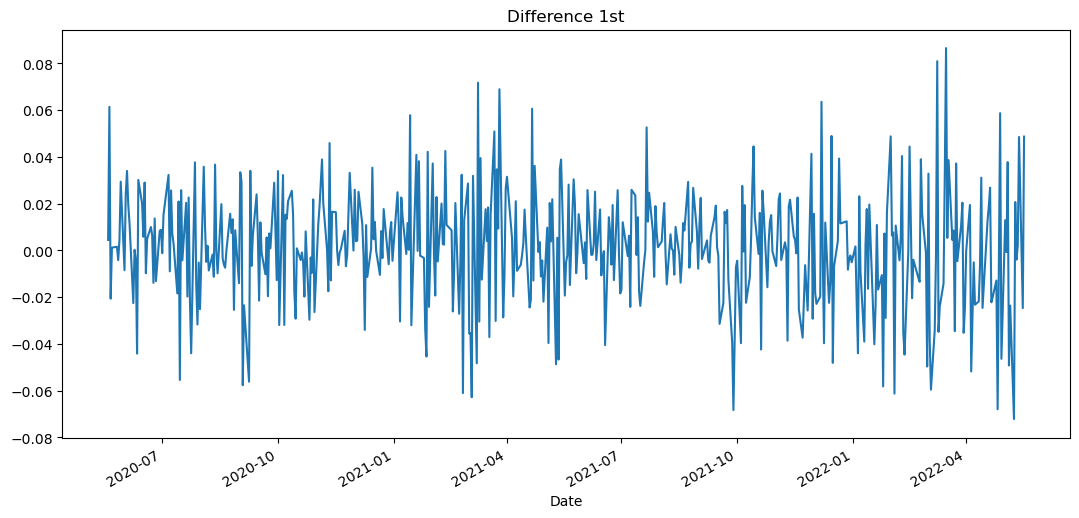

In [90]:
# 1차 차분 구하기
asml_diff_1 = asml_log.diff(periods=1).iloc[1:]
asml_diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(asml_diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.129844e+01
p-value                        1.325758e-20
#Lags Used                     1.000000e+01
Number of Observations Used    4.920000e+02
Critical Value (1%)           -3.443711e+00
Critical Value (5%)           -2.867432e+00
Critical Value (10%)          -2.569908e+00
dtype: float64


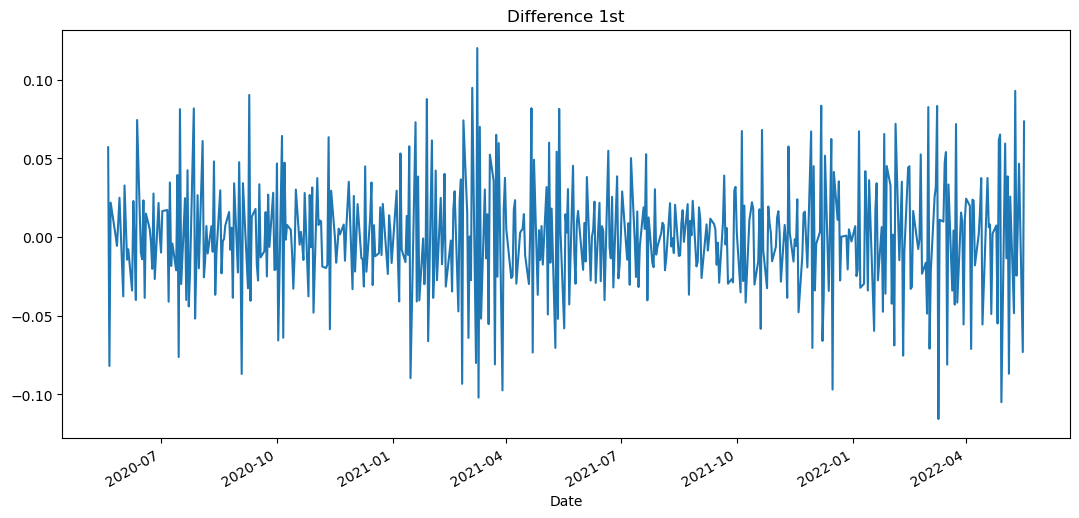

In [92]:
# 2차 차분 구하기
asml_diff_2 = asml_diff_1.diff(periods=1).iloc[1:]
asml_diff_2.plot(title='Difference 1st')

augmented_dickey_fuller_test(asml_diff_2)

- 1차 차분만 한다. 
- acf및 pacf 그래프를 그려본다. 

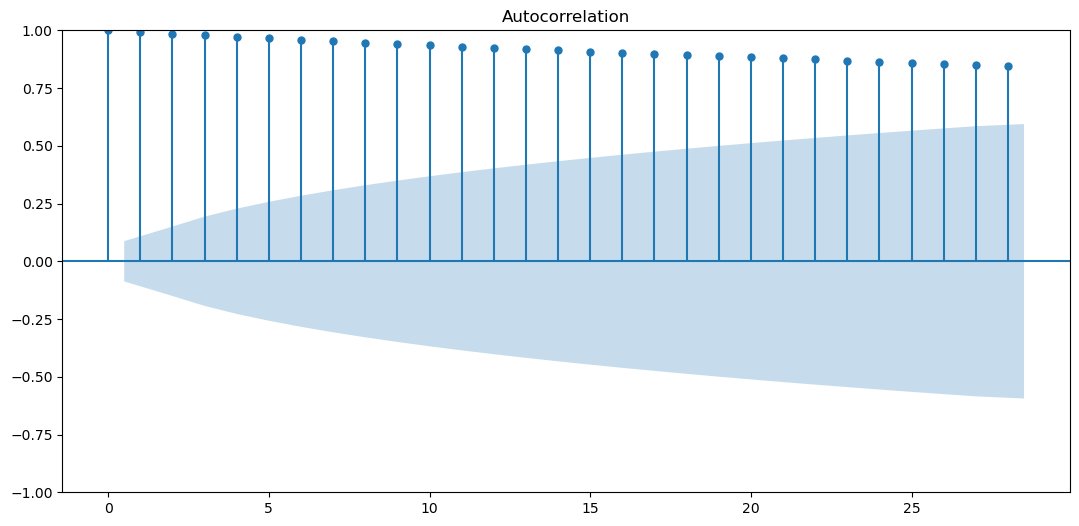

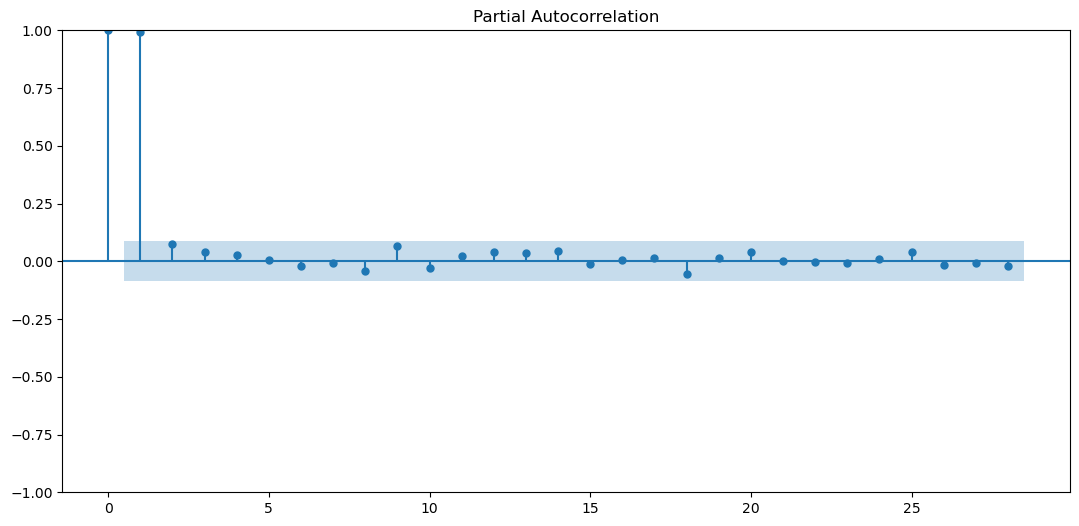

In [93]:
plot_acf(asml_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(asml_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

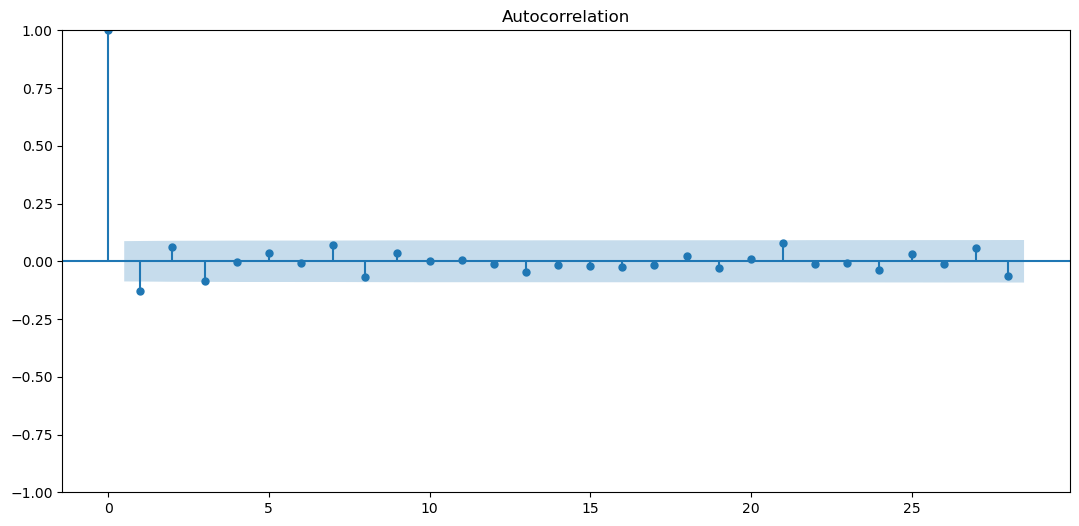

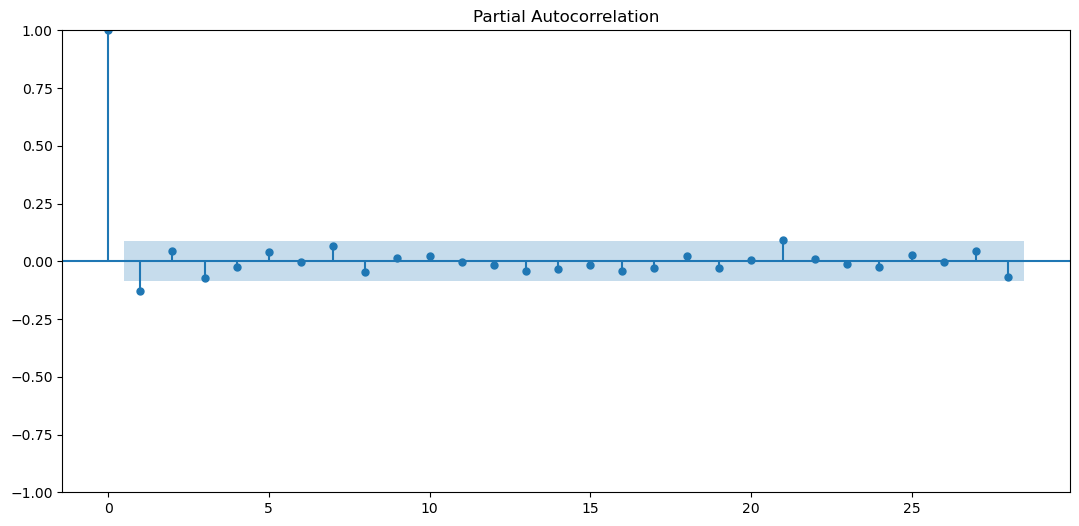

In [94]:
plot_acf(asml_diff_1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(asml_diff_1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- p=1, d=1, q=1을 기본으로 테스트를 진행해본다. 
- p=21, d=0, q=2도 시도해본다. 

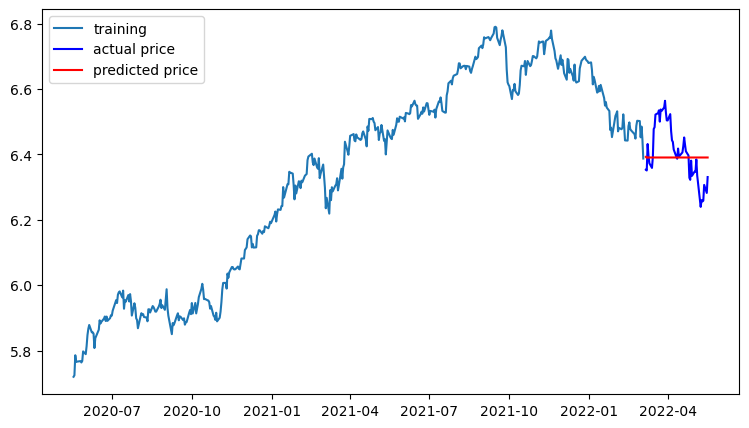

In [96]:
model = ARIMA(train_data, order=(1, 1, 1))
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [97]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  2894.1161067669054
MAE:  43.32993809443633
RMSE:  53.79698975562578
MAPE: 7.00%


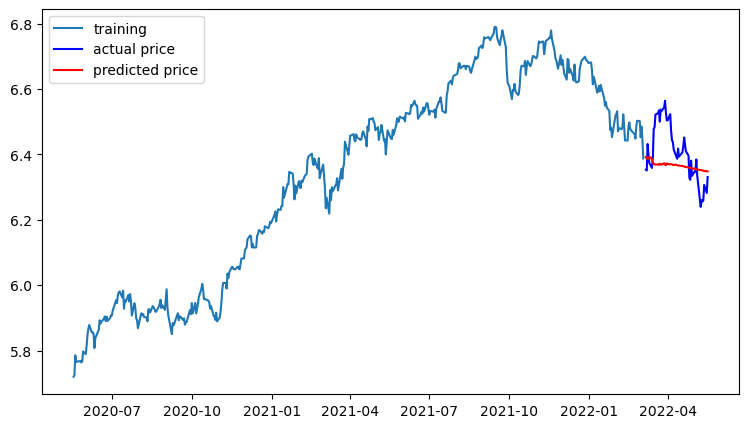

In [99]:
model = ARIMA(train_data, order=(21, 0, 2))
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [100]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3236.9451636430485
MAE:  45.27950570254046
RMSE:  56.89415755280193
MAPE: 7.14%


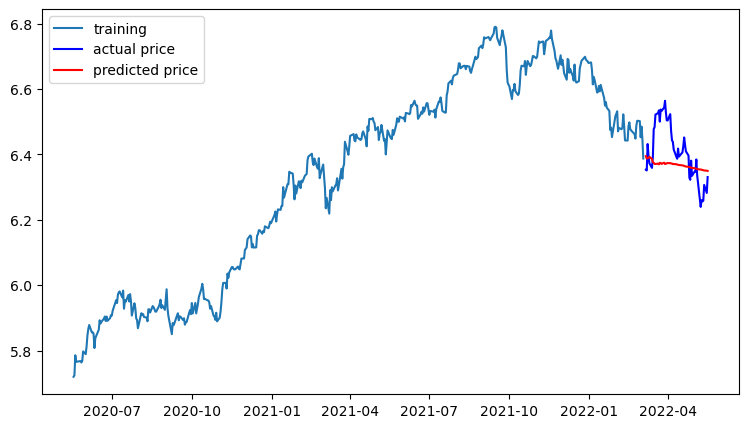

In [101]:
model = ARIMA(train_data, order=(21, 0, 0))
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [102]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3153.5911376249373
MAE:  44.726803352642975
RMSE:  56.15684408533779
MAPE: 7.06%


## INTEL
- 미국 반도체 산업을 대표하는 절대강장
- LOGIC반도체의 근본과도 같은 회사이며, cpu시장에서는 사실상의 독과점 지위를 누리던 회사
- 독과점 이후 기술개발에 투자를 줄이고 증권가에서 원하는 실적위주의 경영을 하다가, AMD의 무서운 추격과 모바일 시대의 도래와 함께, 강력했던 예전의 모습은 많이 상실한 상태 그래도, AMD와 함께 X86시장을 양분하고 있는 강력한 회사이다. 
- 새로운 엔지니어 출신 CEO를 영입해 회사 체질개선 중이다. 

In [103]:
import yfinance as yf
data = yf.download('INTC', start='2020-05-18', end='2022-05-18')
data.info()

data.head()

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 505 entries, 2020-05-18 to 2022-05-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       505 non-null    float64
 1   High       505 non-null    float64
 2   Low        505 non-null    float64
 3   Close      505 non-null    float64
 4   Adj Close  505 non-null    float64
 5   Volume     505 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 27.6 KB


Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2020-05-18  59.740002  60.279999  59.360001  59.919998  55.394073  20428700
2020-05-19  60.130001  61.770000  59.849998  60.290001  55.736122  21865000
2020-05-20  61.160000  63.490002  61.020000  63.099998  58.333870  30584000
2020-05-21  63.099998  63.799999  61.820000  61.980000  57.298473  20987700
2020-05-22  61.980000  62.320000  61.419998  62.259998  57.557323  14103000

#### 그래프 및 로그 그래프 확인

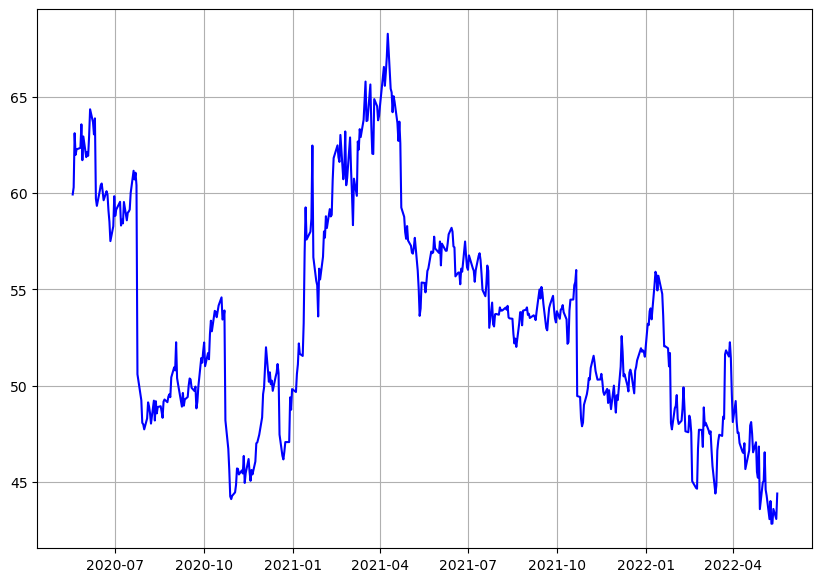

In [104]:
plt.figure(figsize = (10, 7))
plt.grid(True)
plt.plot(data['Close'], c = 'b', label = 'Close Price')
plt.legend
plt.show()

In [105]:
intel_log = np.log(data['Close'])
intel_log

Date
2020-05-18    4.093010
2020-05-19    4.099166
2020-05-20    4.144721
2020-05-21    4.126812
2020-05-22    4.131319
                ...   
2022-05-11    3.757239
2022-05-12    3.757472
2022-05-13    3.775057
2022-05-16    3.763059
2022-05-17    3.793240
Name: Close, Length: 505, dtype: float64

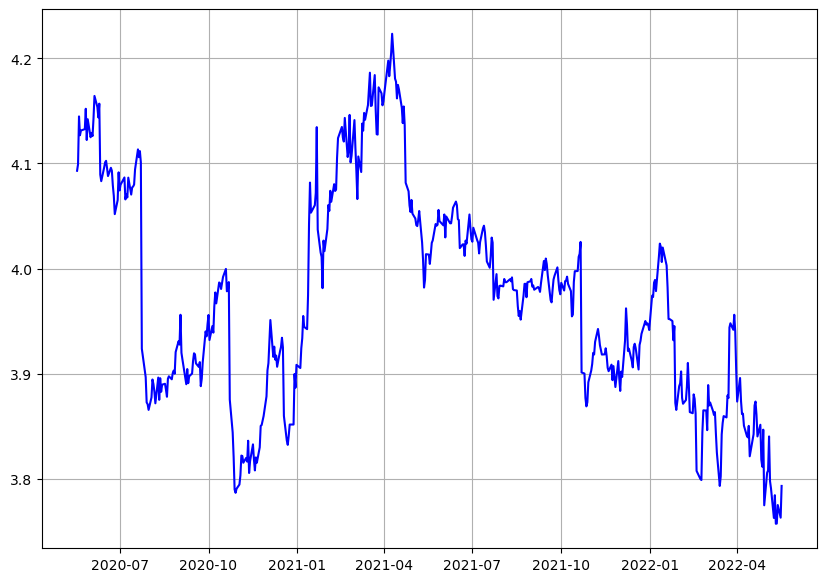

In [106]:
plt.figure(figsize = (10, 7))
plt.grid(True)
plt.plot(intel_log, c = 'b')
plt.show()

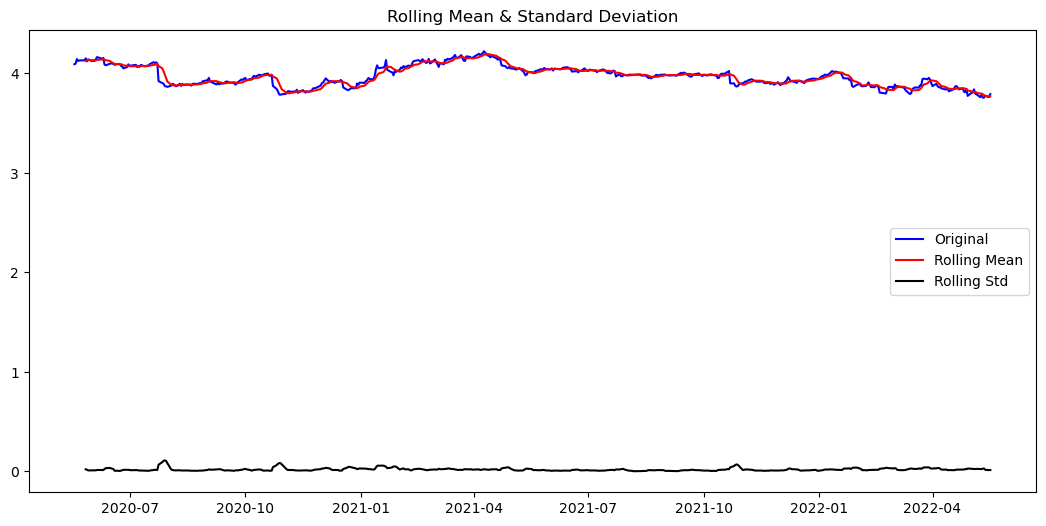

In [107]:
plot_rolling_statistics(intel_log, window=7)

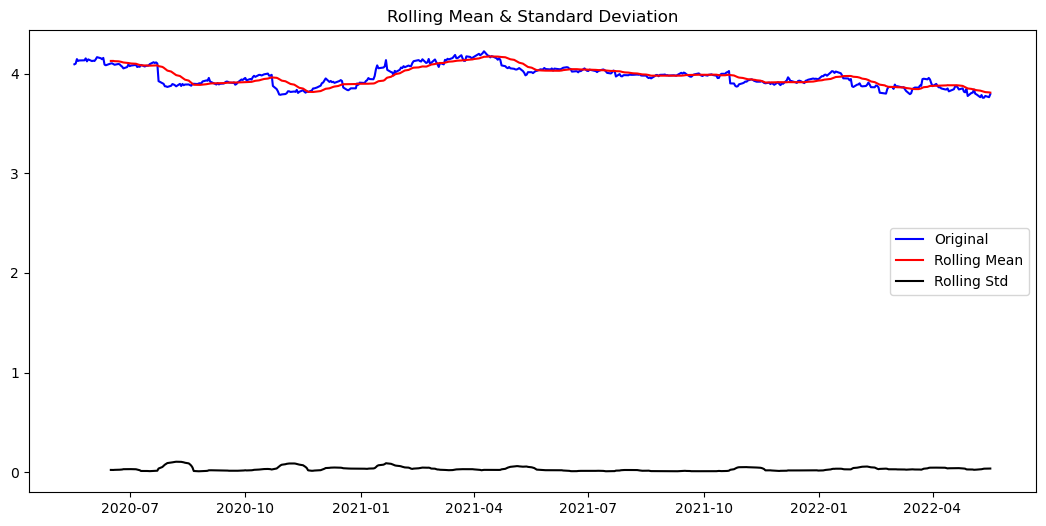

In [108]:
plot_rolling_statistics(intel_log, window=21)

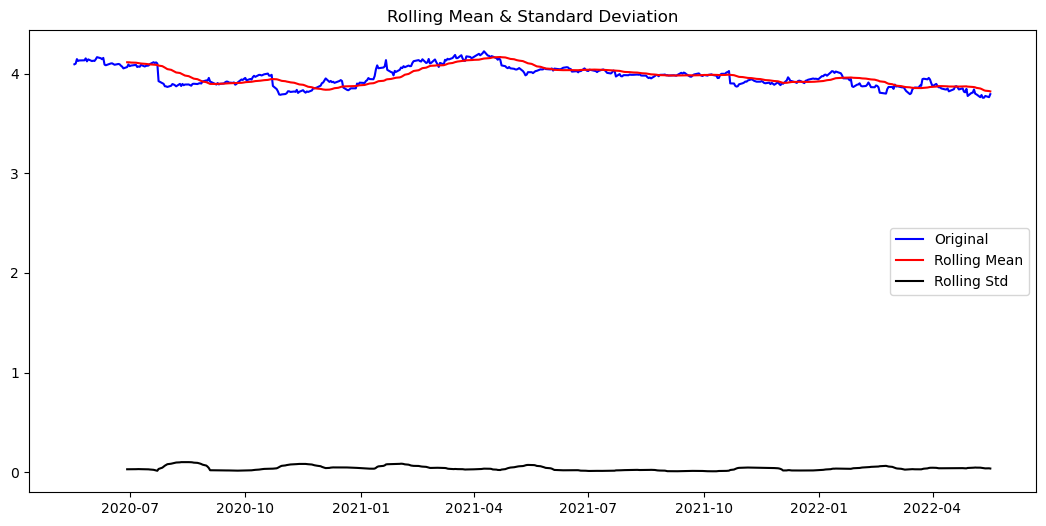

In [110]:
plot_rolling_statistics(intel_log, window=30)

#### 시계열 안정성 분석

In [112]:
augmented_dickey_fuller_test(intel_log)

Results of Dickey-Fuller Test:
Test Statistic                  -2.232869
p-value                          0.194533
#Lags Used                       0.000000
Number of Observations Used    504.000000
Critical Value (1%)             -3.443392
Critical Value (5%)             -2.867292
Critical Value (10%)            -2.569833
dtype: float64


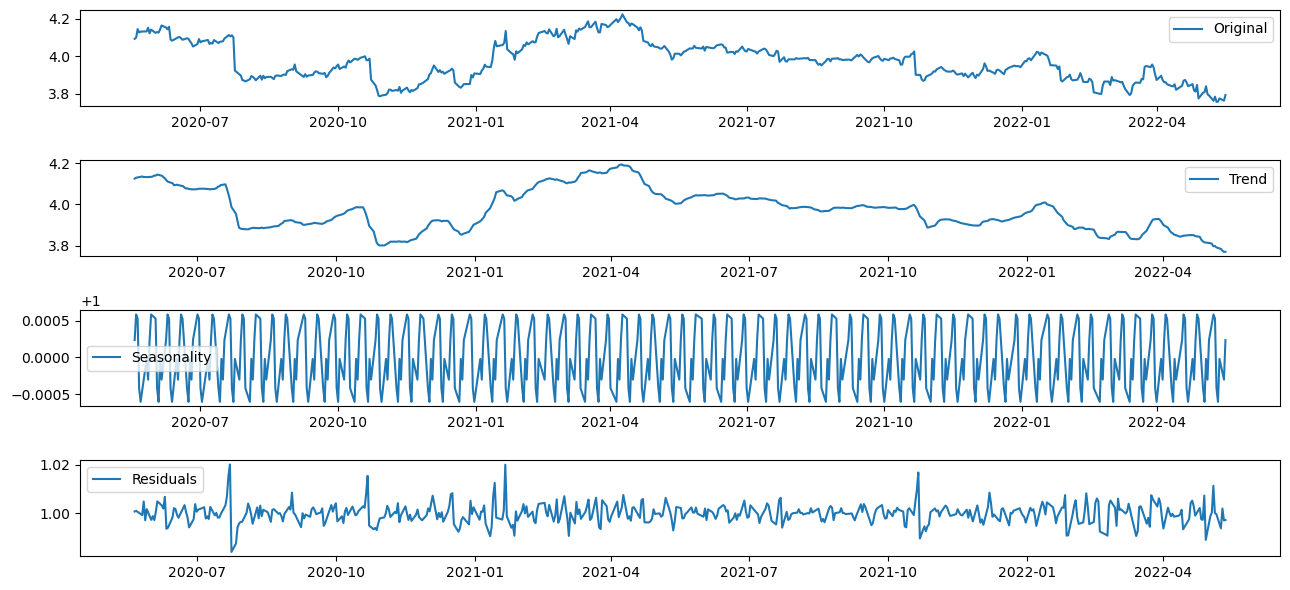

In [115]:
decomposition = seasonal_decompose(intel_log, model='multiplicative', period = 7) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(intel_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [116]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -8.870685e+00
p-value                        1.400706e-14
#Lags Used                     1.800000e+01
Number of Observations Used    4.800000e+02
Critical Value (1%)           -3.444047e+00
Critical Value (5%)           -2.867580e+00
Critical Value (10%)          -2.569987e+00
dtype: float64


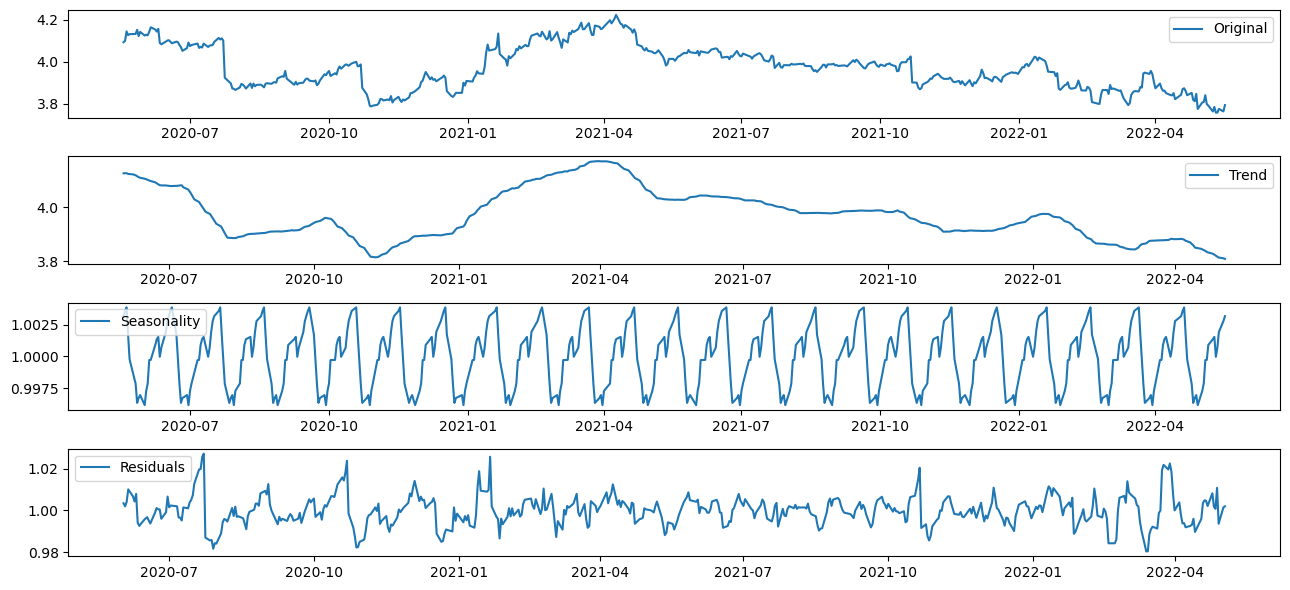

In [117]:
decomposition = seasonal_decompose(intel_log, model='multiplicative', period = 21) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(intel_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [118]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -9.735074e+00
p-value                        8.794373e-17
#Lags Used                     7.000000e+00
Number of Observations Used    4.770000e+02
Critical Value (1%)           -3.444134e+00
Critical Value (5%)           -2.867618e+00
Critical Value (10%)          -2.570008e+00
dtype: float64


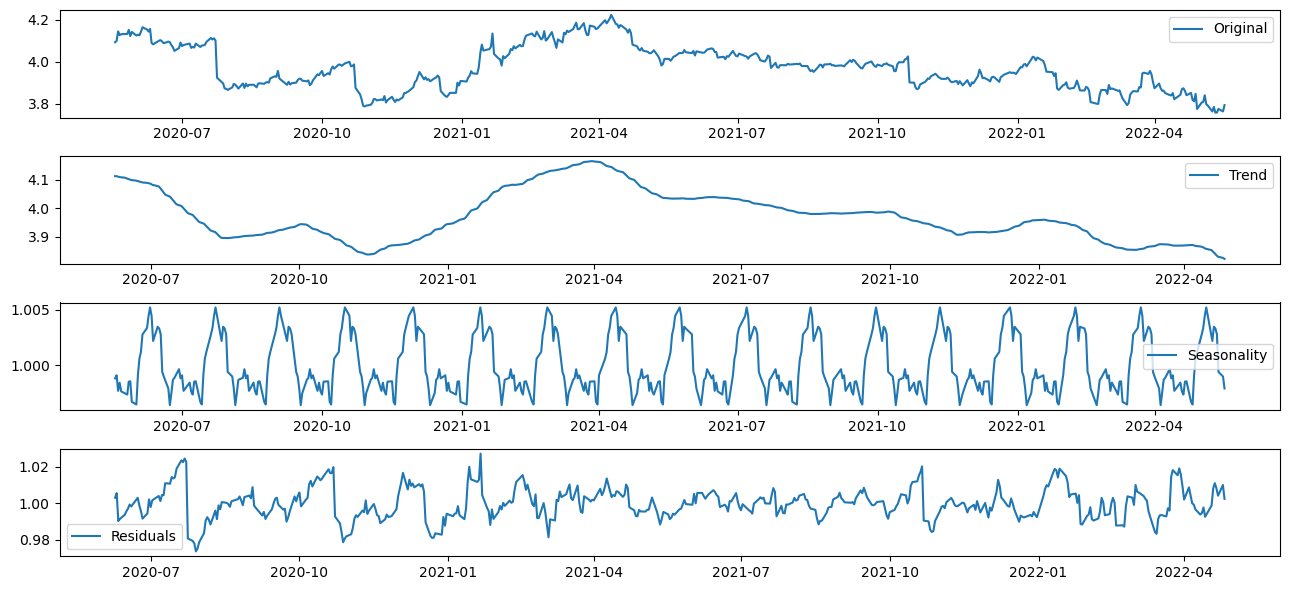

In [119]:
decomposition = seasonal_decompose(intel_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(intel_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [120]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -8.433250e+00
p-value                        1.845700e-13
#Lags Used                     5.000000e+00
Number of Observations Used    4.690000e+02
Critical Value (1%)           -3.444370e+00
Critical Value (5%)           -2.867722e+00
Critical Value (10%)          -2.570063e+00
dtype: float64


#### 훈련데이터 생성

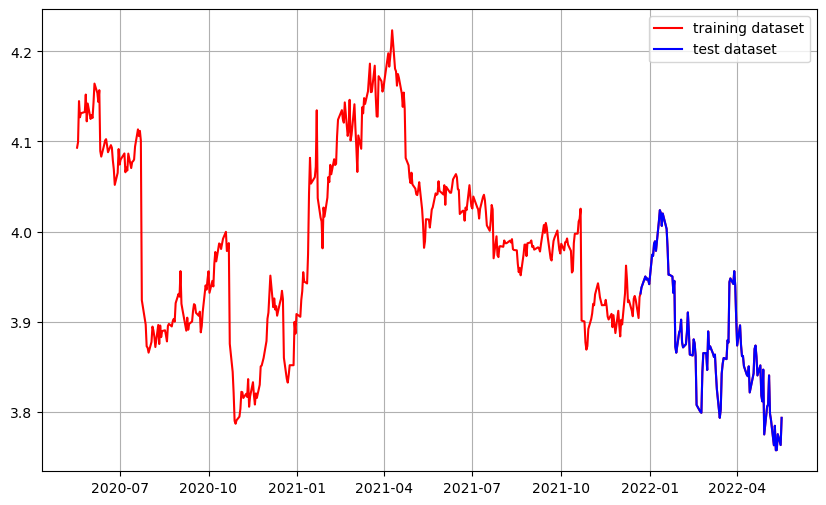

In [121]:
train_data, test_data = intel_log[:int(len(intel_log)*0.8)], intel_log[int(len(intel_log)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(intel_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

#### 차분횟수 확인

Results of Dickey-Fuller Test:
Test Statistic                 -23.346405
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    503.000000
Critical Value (1%)             -3.443418
Critical Value (5%)             -2.867303
Critical Value (10%)            -2.569840
dtype: float64


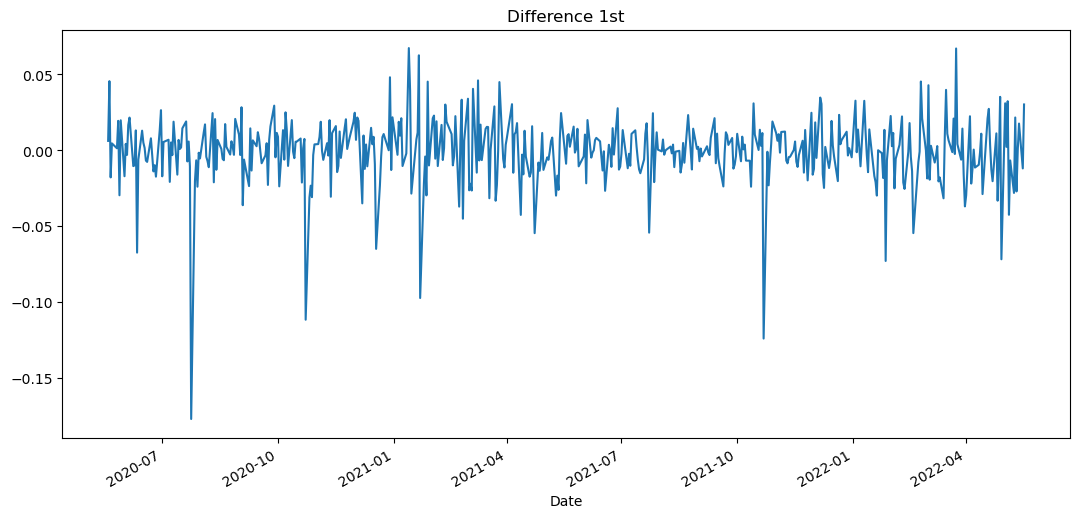

In [122]:
# 1차 차분 구하기
intel_diff_1 = intel_log.diff(periods=1).iloc[1:]
intel_diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(intel_diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -9.176624e+00
p-value                        2.310831e-15
#Lags Used                     1.800000e+01
Number of Observations Used    4.840000e+02
Critical Value (1%)           -3.443933e+00
Critical Value (5%)           -2.867530e+00
Critical Value (10%)          -2.569961e+00
dtype: float64


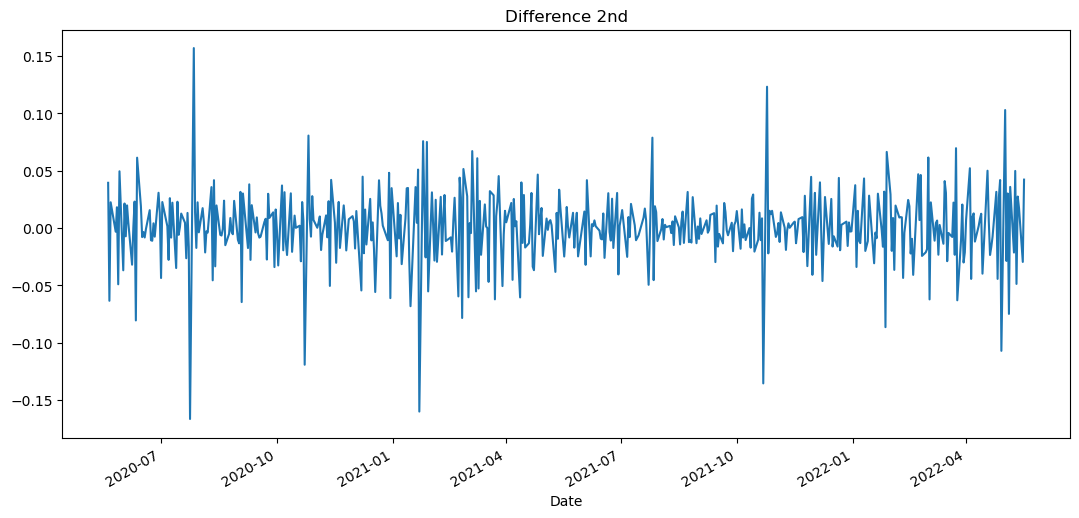

In [123]:
# 1차 차분 구하기
intel_diff_2 = intel_diff_1.diff(periods=1).iloc[1:]
intel_diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(intel_diff_2)

- acf 및 pacf를 그린다. 

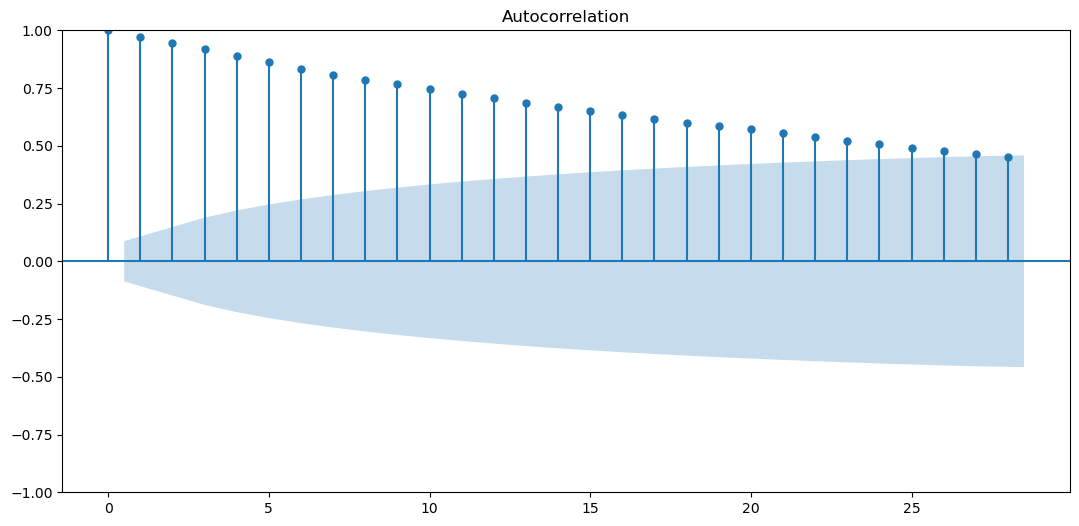

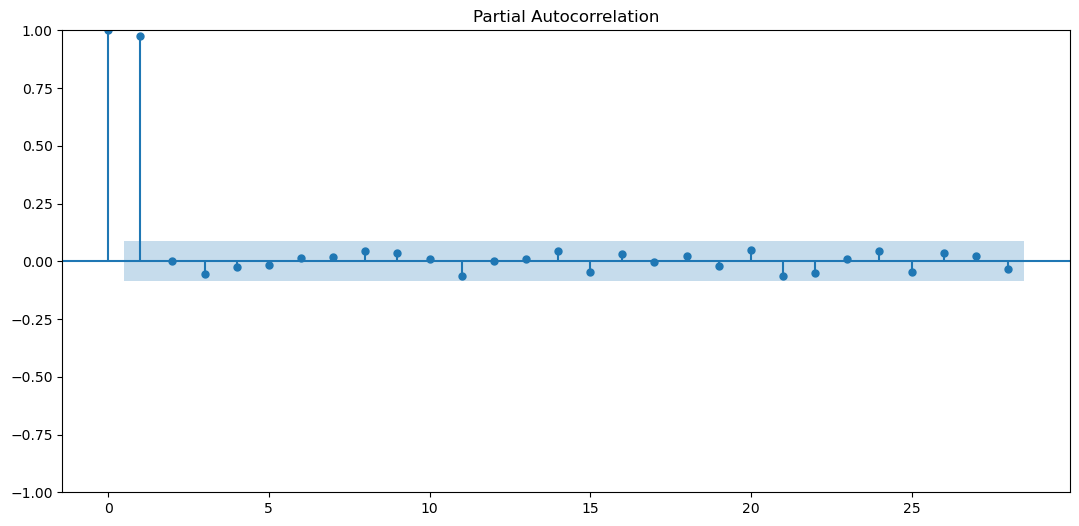

In [124]:
plot_acf(intel_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(intel_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

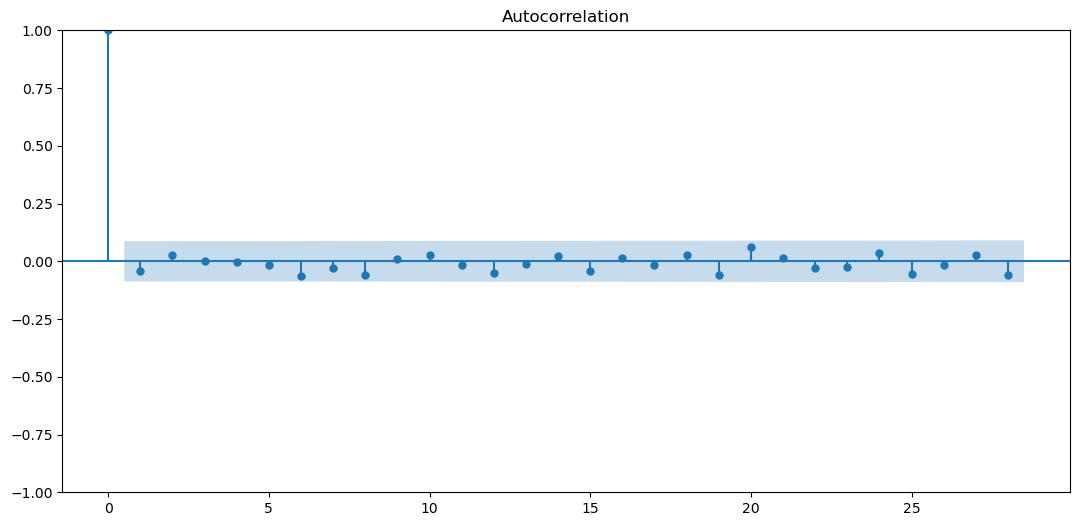

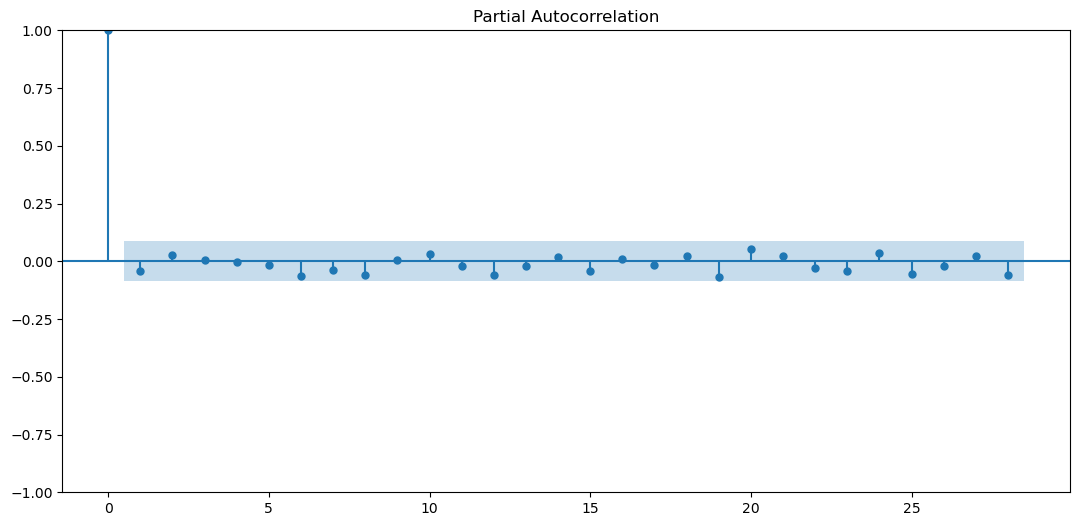

In [125]:
plot_acf(intel_diff_1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(intel_diff_1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- p=0, d=1, q=0을 기본으로 테스트를 진행해본다. 
- p=21, d=0, q=1도 시도해본다. 

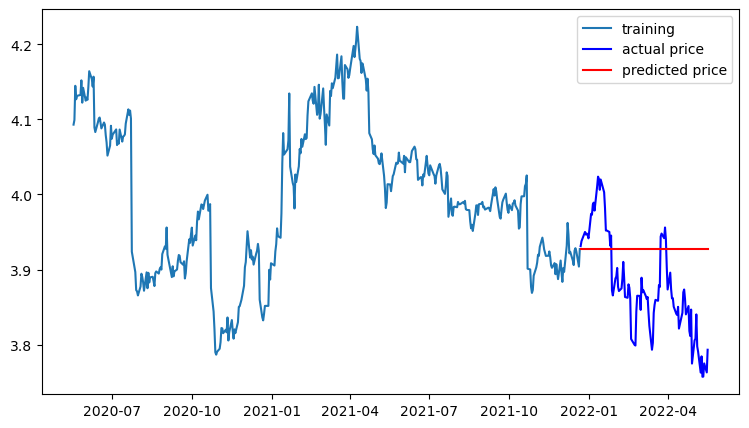

In [126]:
model = ARIMA(train_data, order=(0, 1, 0))
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [127]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  15.361720144715086
MAE:  3.4199009885882363
RMSE:  3.9194030342279276
MAPE: 7.25%


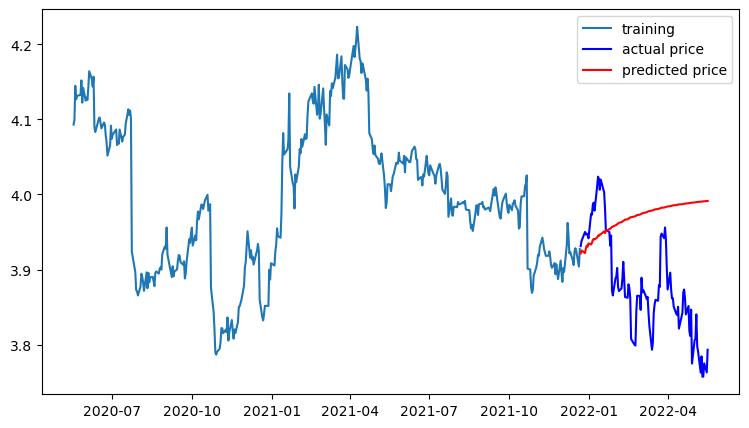

In [128]:
model = ARIMA(train_data, order=(21, 0, 1))
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [129]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  36.12337204861315
MAE:  5.254942712272729
RMSE:  6.010272210858103
MAPE: 11.23%


# 회고

### 신경쓴점 
- pdq값을 최대한 분석에 기초해서 도출하려 노력했다. 
- 다양한 pdq값을 시도하고, 그래프를 통해 예측 정확도를 확인했다. 

### 아쉬운점
- 여전히 시계열 분석의 원리가 와닿지 않는다
- acf나 pacf 그래프를 통해 도출해낸, pdq값이 가장 정확한 예측치가 아니었다. 

### 레퍼런스
- LMS
- https://leedakyeong.tistory.com/entry/Python-%EB%82%A0%EC%94%A8-%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%8D%B0%EC%9D%B4%ED%84%B0Kaggle%EB%A1%9C-ARIMA-%EC%A0%81%EC%9A%A9%ED%95%98%EA%B8%B0